# Creating the env

In [91]:
import os
import sys
import subprocess

# Define environment name
venv_dir = "gut_microbiome_env"

# In Colab, virtual environments are not typically activated in the same way as local machines
# We will directly install packages to the Colab environment.

packages = [
    "numpy", "pandas", "matplotlib", "seaborn", "scikit-learn",
    "umap-learn", "h5py", "scikit-bio", "biom-format", "scipy"
]

# Install packages directly into the Colab environment
print("Installing required packages...")
for pkg in packages:
    subprocess.run([sys.executable, "-m", "pip", "install", pkg])
print("All packages installed.")

# The virtual environment creation is kept, but its activation is not needed for package installation this way.
if not os.path.exists(venv_dir):
    print(f"Creating virtual environment '{venv_dir}' (for completeness, though packages are installed globally)...")
    subprocess.run([sys.executable, "-m", "venv", venv_dir])
    print("Virtual environment created.")


Installing required packages...
All packages installed.


In [92]:
!source gut_microbiome_env/bin/activate

In [93]:
import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.decomposition import PCA
import seaborn as sns

In [94]:
sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


# Load Data

In [95]:
# Load data
data_dir = "data"
ab_path = os.path.join(data_dir, "MetaCardis2020_relative_abundance.csv")
meta_path = os.path.join(data_dir, "MetaCardis2020_sample_metadata.csv")
taxa_meta_path = os.path.join(data_dir, "MetaCardis2020_taxa_metadata.csv")

RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")
os.makedirs(FIGS, exist_ok=True); os.makedirs(TABLES, exist_ok=True)


In [96]:
ab_raw = pd.read_csv(ab_path, index_col=0)
meta = pd.read_csv(meta_path, index_col=0)
taxa_meta = pd.read_csv(taxa_meta_path, index_col=0)

print("ab_raw.shape (rows x cols):", ab_raw.shape)
print("meta.shape:", meta.shape)
print("taxa_meta.shape:", taxa_meta.shape)
display(ab_raw.head().T)   
display(meta.head())
display(taxa_meta.head())

ab_raw.shape (rows x cols): (697, 1831)
meta.shape: (1831, 25)
taxa_meta.shape: (697, 7)


taxa,Bacteroides uniformis,Phocaeicola dorei,Alistipes finegoldii,Phocaeicola vulgatus,Eubacterium sp. CAG:180
M0x10MCx1134,18.68909,10.88477,8.14016,7.69579,5.24825
M0x10MCx1135,0.47634,0.12509,0.11658,0.06780,5.09389
M0x10MCx1138,1.69175,19.99088,0.31639,1.37651,0.00000
M0x10MCx1140,8.54740,8.29615,0.00000,2.42549,0.00000
M0x10MCx1143,11.01829,28.54958,0.00000,0.00000,0.00000
...,...,...,...,...,...
M0x30MCx3384,1.09316,0.14840,0.00000,1.80244,2.05756
M0x30MCx3412,38.16991,4.62311,0.17234,5.02784,0.00000
M0x30MCx3414,0.90933,1.27721,0.73518,1.56852,3.94000
M0x30MCx3422,7.93352,1.23356,0.91919,3.94948,0.00000


,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age_category,gender,country,non_westernized,...,BMI,treatment,location,disease_subtype,triglycerides,hba1c,smoke,bristol_score,hsCRP,LDL
M0x10MCx1134,MetaCardis_2020_a,M0x10MCx1134,stool,no,IGT,IGT;MS,adult,female,FRA,no,...,44.365888,antihta;thiazidique;at2_inhib,Paris,NaN,97.940706,6.0,no,1.0,1.3,140.673726
M0x10MCx1135,MetaCardis_2020_a,M0x10MCx1135,stool,no,T2D,T2D,adult,male,FRA,no,...,27.719670,antidiab;su;metformin;dppiv;insulin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1138,MetaCardis_2020_a,M0x10MCx1138,stool,yes,T2D,T2D,adult,male,FRA,no,...,38.221055,antidiab;su;metformin,Paris,NaN,NaN,NaN,1.0,NaN,NaN,NaN
M0x10MCx1140,MetaCardis_2020_a,M0x10MCx1140,stool,NaN,control,MS,adult,female,FRA,no,...,36.283006,antihta;thiazidique;at2_inhib;ca2_cbl,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1143,MetaCardis_2020_a,M0x10MCx1143,stool,yes,T2D,T2D,senior,female,FRA,no,...,39.817729,antihta;antidiab;thiazidique;at2_inhib;metformin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN


,superkingdom,phylum,class,order,family,genus,species
Bacteroides uniformis,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides uniformis
Phocaeicola dorei,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola dorei
Alistipes finegoldii,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes finegoldii
Phocaeicola vulgatus,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola vulgatus
Eubacterium sp. CAG:180,Bacteria,Firmicutes,Clostridia,Eubacteriales,Eubacteriaceae,Eubacterium,Eubacterium sp. CAG:180


In [97]:
#transpose abundance and check alignment
ab = ab_raw.T.copy()   # rows = samples, cols = taxa
print("ab (samples x taxa) shape:", ab.shape)

print("First 5 sample IDs in abundance:", list(ab.index[:5]))
print("First 5 sample IDs in metadata:", list(meta.index[:5]))

# how many sample IDs overlap between abundance and metadata?
common = ab.index.intersection(meta.index)
print(f"Common sample IDs: {len(common)} / {ab.shape[0]} (abundance) and {meta.shape[0]} (metadata)")

ab (samples x taxa) shape: (1831, 697)
First 5 sample IDs in abundance: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
First 5 sample IDs in metadata: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
Common sample IDs: 1831 / 1831 (abundance) and 1831 (metadata)


In [98]:
# show up to 5 example mismatches (if any)
ab_only = list(sorted(set(ab.index) - set(meta.index)))[:5]
meta_only = list(sorted(set(meta.index) - set(ab.index)))[:5]
print("Example sample IDs present in abundance but NOT in metadata:", ab_only)
print("Example sample IDs present in metadata but NOT in abundance:", meta_only)

Example sample IDs present in abundance but NOT in metadata: []
Example sample IDs present in metadata but NOT in abundance: []


In [99]:
#Check duplicates and missingness

# Check for duplicate sample IDs
dup_ab = ab.index[ab.index.duplicated()]
dup_meta = meta.index[meta.index.duplicated()]
print("Duplicate samples in abundance:", len(dup_ab))
print("Duplicate samples in metadata:", len(dup_meta))

# Check for missing values in metadata
missing_counts = meta.isna().sum().sort_values(ascending=False)
print("\nTop 10 metadata columns with missing values:")
print(missing_counts.head(10))

Duplicate samples in abundance: 0
Duplicate samples in metadata: 0

Top 10 metadata columns with missing values:
disease_subtype            1822
hsCRP                      1002
bristol_score               997
hba1c                       992
LDL                         990
triglycerides               987
smoke                       528
BMI                         521
gender                      514
antibiotics_current_use     104
dtype: int64


In [101]:
# Look at unique values in the disease/study_condition columns
print("Unique values in 'study_condition':", meta['study_condition'].unique()[:10])
print("Unique values in 'disease':", meta['disease'].unique()[:10])

Unique values in 'study_condition': ['IGT' 'T2D' 'control' 'CAD' 'HF']
Unique values in 'disease': ['IGT;MS' 'T2D' 'MS' 'CAD' 'CAD;T2D' 'HF;T2D' 'healthy' 'IGT' 'MA'
 'HF;CAD']


In [102]:
# create unified Healthy vs Disease label
def map_health(row):
    cond = str(row['study_condition']).lower()
    dis = str(row['disease']).lower()
    if ('control' in cond) or ('healthy' in dis):
        return 'Healthy'
    else:
        return 'Disease'

meta['health_status'] = meta.apply(map_health, axis=1)

# Check how many samples in each class
print("Health status counts:")
print(meta['health_status'].value_counts(dropna=False))

# Drop samples with no label (if any)
meta = meta.dropna(subset=['health_status'])
ab = ab.loc[meta.index]
print("After removing unlabeled samples -> samples:", ab.shape[0])

Health status counts:
health_status
Disease    1189
Healthy     642
Name: count, dtype: int64
After removing unlabeled samples -> samples: 1831


In [103]:
# Clean antibiotics and treatment columns

if 'antibiotics_current_use' in meta.columns:
    meta['antibiotics_current_use'] = (
        meta['antibiotics_current_use']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )

    # Standardize values
    def clean_antibiotic(x):
        if pd.isna(x):
            return 'unknown'
        elif x.startswith('y'):
            return 'yes'
        elif x.startswith('n'):
            return 'no'
        else:
            return 'unknown'

    meta['antibiotic_use'] = meta['antibiotics_current_use'].apply(clean_antibiotic)
else:
    # If the column doesn't exist, create an empty one
    meta['antibiotic_use'] = 'unknown'

print("Antibiotic use value counts:")
print(meta['antibiotic_use'].value_counts(dropna=False))

# Clean treatment information (string normalization)
if 'treatment' in meta.columns:
    meta['treatment'] = (
        meta['treatment']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )
else:
    meta['treatment'] = np.nan


print("\nMost common treatments:")
print(meta['treatment'].value_counts().head(10))


Antibiotic use value counts:
antibiotic_use
no         944
yes        783
unknown    104
Name: count, dtype: int64

Most common treatments:
treatment
no                                                       539
ppi                                                       32
antidiab;metformin                                        25
antihta;ace_inhib                                         24
antilipid;antihta;beta_blockers;statin;antithombo;asa     24
antihta;beta_blockers                                     21
antilipid;statin                                          20
antidiab;metformin;dppiv                                  18
antihta;at2_inhib                                         17
antilipid;statin;asa                                      15
Name: count, dtype: int64


In [104]:
# How many samples in the dataset
n_samples = ab.shape[0]

# Count in how many samples each taxon appears (>0)
prevalence = (ab > 0).sum(axis=0)

n_samples
prevalence

taxa
Bacteroides uniformis             1756
Phocaeicola dorei                 1297
Alistipes finegoldii              1489
Phocaeicola vulgatus              1640
Eubacterium sp. CAG:180            688
                                  ... 
Mageeibacillus indolicus             1
Dialister micraerophilus             1
Tissierellia bacterium KA00581       1
Anaerococcus lactolyticus            1
Actinomyces naeslundii               1
Length: 697, dtype: int64

In [105]:
# Filter rare taxa (low prevalence)

# Choose a threshold (e.g. ≥5 % of samples)
min_samples = math.ceil(0.05 * n_samples)
keep_taxa = prevalence[prevalence >= min_samples].index
print(f"Keeping {len(keep_taxa)} taxa out of {ab.shape[1]} (≥5% prevalence)")

# Filter the abundance table
ab_filt = ab[keep_taxa].copy()
print("Filtered abundance shape:", ab_filt.shape)

# also make a 1% version to test sensitivity later
min_samples_1pct = math.ceil(0.01 * n_samples)
keep_taxa_1pct = prevalence[prevalence >= min_samples_1pct].index
ab_filt_1pct = ab[keep_taxa_1pct].copy()
print("1% version shape:", ab_filt_1pct.shape)


Keeping 228 taxa out of 697 (≥5% prevalence)
Filtered abundance shape: (1831, 228)
1% version shape: (1831, 362)


In [106]:
# Normalize filtered table to relative abundances (sum = 1 per sample)

# use 1% filtered version for main analysis
ab_rel = ab_filt_1pct.div(ab_filt_1pct.sum(axis=1), axis=0).fillna(0)

# every sample should now sum ≈ 1
sample_sums = ab_rel.sum(axis=1)
print("Relative-abundance sample sums (min–max):", sample_sums.min(), "-", sample_sums.max())

# if any sample sums = 0 → drop it 
zero_sum = sample_sums[sample_sums == 0].index
if len(zero_sum) > 0:
    print("Dropping", len(zero_sum), "zero-sum samples")
    ab_rel = ab_rel.drop(index=zero_sum)
    meta = meta.loc[ab_rel.index]

print("Normalized abundance shape:", ab_rel.shape)

# Save normalized version
ab_rel.to_csv(os.path.join(TABLES, "abundance_filtered5pct_relative.csv"))


Relative-abundance sample sums (min–max): 0.9999999999999984 - 1.0000000000000013
Normalized abundance shape: (1831, 362)


In [107]:
# Define diversity functions
def shannon(p):
    p = p[p > 0]
    return -(p * np.log(p)).sum()

def simpson(p):
    return 1 - (p**2).sum()

# Compute metrics for each sample
alpha = pd.DataFrame(index=ab_rel.index)
alpha['richness'] = (ab_rel > 0).sum(axis=1)
alpha['shannon'] = ab_rel.apply(shannon, axis=1)
alpha['simpson'] = ab_rel.apply(simpson, axis=1)

# Merge key metadata (for plotting & stratification)
alpha = alpha.join(meta[['health_status', 'antibiotic_use', 'treatment']])
alpha.head()

,richness,shannon,simpson,health_status,antibiotic_use,treatment
M0x10MCx1134,83,3.104653,0.924697,Disease,no,antihta;thiazidique;at2_inhib
M0x10MCx1135,93,2.089916,0.663610,Disease,no,antidiab;su;metformin;dppiv;insulin
M0x10MCx1138,73,2.561503,0.845013,Disease,yes,antidiab;su;metformin
M0x10MCx1140,95,3.305604,0.944692,Healthy,unknown,antihta;thiazidique;at2_inhib;ca2_cbl
M0x10MCx1143,46,2.235294,0.835720,Disease,yes,antihta;antidiab;thiazidique;at2_inhib;metformin


/var/folders/mh/p8rsw7z90bv6kv8r8qnf4tnr0000gn/T/ipykernel_9054/1808792328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='health_status', y='shannon', data=alpha, inner=None, palette='Set2')


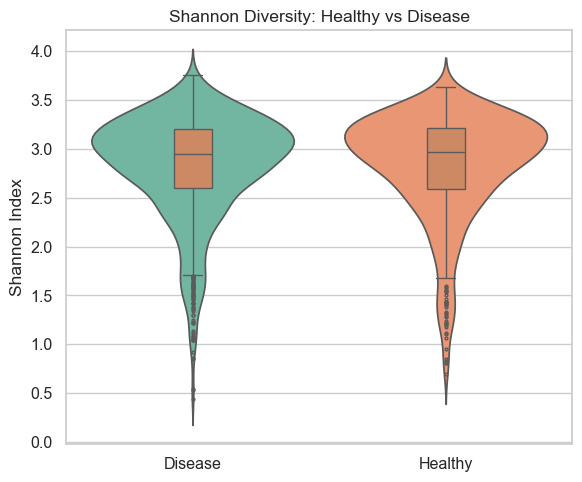

In [17]:
# Visualize Shannon diversity by health status
plt.figure(figsize=(6,5))
sns.violinplot(x='health_status', y='shannon', data=alpha, inner=None, palette='Set2')
sns.boxplot(x='health_status', y='shannon', data=alpha, width=0.15, showcaps=True, boxprops={'zorder':2}, fliersize=2)
plt.title("Shannon Diversity: Healthy vs Disease")
plt.ylabel("Shannon Index")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "shannon_by_health_vs_disease.png"), dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# Mann–Whitney U test for diversity difference
healthy = alpha.loc[alpha['health_status'] == 'Healthy', 'shannon']
disease = alpha.loc[alpha['health_status'] == 'Disease', 'shannon']

u_stat, p_val = mannwhitneyu(healthy, disease, alternative='two-sided')
print(f"Mann–Whitney test (Shannon, Healthy vs Disease): p = {p_val:.3e}, U = {u_stat}")
print(f"Healthy mean = {healthy.mean():.3f}, Disease mean = {disease.mean():.3f}")


Mann–Whitney test (Shannon, Healthy vs Disease): p = 6.539e-01, U = 386510.0
Healthy mean = 2.824, Disease mean = 2.825


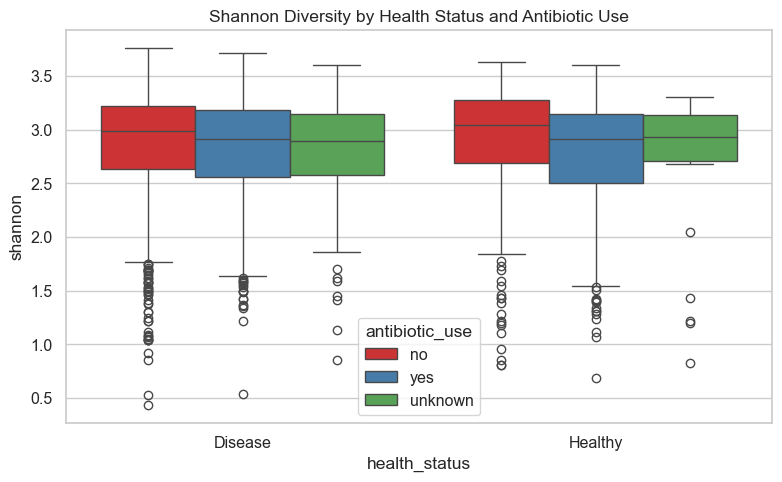

In [19]:
# Shannon diversity by health status & antibiotic use
plt.figure(figsize=(8,5))
sns.boxplot(x='health_status', y='shannon', hue='antibiotic_use', data=alpha, palette='Set1')
plt.title("Shannon Diversity by Health Status and Antibiotic Use")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "shannon_by_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


In [20]:
for abx in ['yes', 'no']:
    sub = alpha[alpha['antibiotic_use'] == abx]
    if len(sub['health_status'].unique()) == 2:
        h = sub.loc[sub['health_status'] == 'Healthy', 'shannon']
        d = sub.loc[sub['health_status'] == 'Disease', 'shannon']
        u, p = mannwhitneyu(h, d, alternative='two-sided')
        print(f"Antibiotic={abx}: p={p:.3e}, n_Healthy={len(h)}, n_Disease={len(d)}")


Antibiotic=yes: p=3.376e-01, n_Healthy=297, n_Disease=486
Antibiotic=no: p=8.942e-02, n_Healthy=319, n_Disease=625


In [108]:
# Does antibiotic use itself reduce Shannon diversity?
yes_abx = alpha.loc[alpha['antibiotic_use'] == 'yes', 'shannon']
no_abx = alpha.loc[alpha['antibiotic_use'] == 'no', 'shannon']

u_abx, p_abx = mannwhitneyu(yes_abx, no_abx, alternative='two-sided')
print(f"Antibiotic (yes vs no): p={p_abx:.3e}, mean yes={yes_abx.mean():.3f}, mean no={no_abx.mean():.3f}")


Antibiotic (yes vs no): p=1.161e-04, mean yes=2.799, mean no=2.855


In [22]:
alpha.to_csv(os.path.join(TABLES, "alpha_diversity.csv"))

## CLR transform

In [109]:
# 1) CLR transform
# Settings
pseudocount = 1e-6
n_components = 30
top_loadings = 15

# Ensure ab_rel is a DataFrame with samples x taxa and rows sum ~1
print("ab_rel shape:", ab_rel.shape)
print("Row sums (min, max):", ab_rel.sum(axis=1).min(), ab_rel.sum(axis=1).max())

ab_rel shape: (1831, 362)
Row sums (min, max): 0.9999999999999984 1.0000000000000013


In [110]:
# Add pseudocount and renormalize
X = ab_rel.copy().astype(float)
X_pseudo = X + pseudocount

# Compute geometric mean per sample (for CLR)
gm = np.exp(np.log(X_pseudo).mean(axis=1))

# CLR: log(x) - log(gm)
clr = np.log(X_pseudo).subtract(np.log(gm), axis=0)

print("CLR shape:", clr.shape)
print("CLR per-sample mean (should be ~0):")
print(clr.mean(axis=1).head())

# Save CLR table
clr_path = os.path.join(TABLES, "abundance_clr_1pct_pseudocount{:.0e}.csv".format(pseudocount))
clr.to_csv(clr_path)
print("Saved CLR table to:", clr_path)

CLR shape: (1831, 362)
CLR per-sample mean (should be ~0):
M0x10MCx1134    5.177933e-14
M0x10MCx1135    6.400773e-14
M0x10MCx1138    7.291896e-14
M0x10MCx1140    7.274721e-14
M0x10MCx1143    7.141740e-14
dtype: float64
Saved CLR table to: data/results_EDA/tables/abundance_clr_1pct_pseudocount1e-06.csv


## PCA on CLR-transformed data

In [111]:
#PCA
pca = PCA(n_components=n_components, svd_solver='auto')
pca_res = pca.fit(clr.values)

# Build results dataframes
pcs = pd.DataFrame(pca_res.transform(clr.values),
                   index=clr.index,
                   columns=[f"PC{i+1}" for i in range(pca_res.n_components_)])
explained = pd.Series(pca_res.explained_variance_ratio_,
                      index=[f"PC{i+1}" for i in range(pca_res.n_components_)],
                      name="explained_variance_ratio")

loadings = pd.DataFrame(pca_res.components_.T,
                        index=clr.columns,
                        columns=[f"PC{i+1}" for i in range(pca_res.n_components_)])

# Merge PCs with metadata for plotting
pcs_meta = pcs.join(meta[['health_status', 'antibiotic_use', 'treatment']], how='left')

# Print variance explained
print("\nExplained variance ratio (first 10 PCs):")
print(explained.head(10).round(4))
print("Cumulative variance explained (first 3 PCs):", explained.iloc[:3].sum().round(4))


Explained variance ratio (first 10 PCs):
PC1     0.0862
PC2     0.0455
PC3     0.0333
PC4     0.0255
PC5     0.0207
PC6     0.0163
PC7     0.0157
PC8     0.0145
PC9     0.0133
PC10    0.0129
Name: explained_variance_ratio, dtype: float64
Cumulative variance explained (first 3 PCs): 0.1649


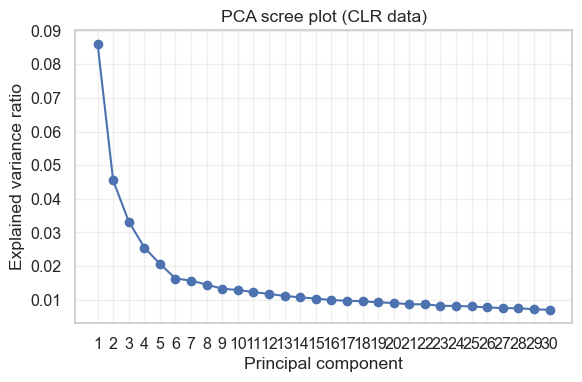

Saved scree plot to: data/results_EDA/figures/pca_scree_clr.png


In [112]:
# Scree plot

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(explained)+1), explained.values, marker='o')
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("PCA scree plot (CLR data)")
plt.xticks(np.arange(1, len(explained)+1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
scree_path = os.path.join(FIGS, "pca_scree_clr.png")
plt.savefig(scree_path, dpi=150)
plt.show()
print("Saved scree plot to:", scree_path)

# Beta Diversity

In [113]:
# PCoA via eigen-decomposition
def pcoa_from_distance(D, k=2):
    """
    Classical metric MDS (PCoA) from a precomputed distance matrix D.
    Returns coordinates (N x k) and explained variance ratios.
    """
    # Double-centering
    D2 = D ** 2
    n = D.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J @ D2 @ J

    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep only positive eigenvalues
    pos = eigvals > 0
    eigvals_pos = eigvals[pos]
    eigvecs_pos = eigvecs[:, pos]

    # Coordinates
    coords = eigvecs_pos[:, :k] * np.sqrt(eigvals_pos[:k])

    # Variance explained (only positive eigvals make sense)
    var_exp = eigvals_pos / eigvals_pos.sum()
    var_ratio = var_exp[:k]
    return coords, var_ratio


In [114]:
## 1) BRAY–CURTIS distance + PCoA

# Compute Bray–Curtis distance on relative abundance (samples x taxa)
bc_dist = pdist(ab_rel.values, metric='braycurtis')
bc_DM = squareform(bc_dist)  # (N x N)

# PCoA coordinates
bc_coords, bc_var = pcoa_from_distance(bc_DM, k=2)

# Build a plotting frame with metadata
bc_df = pd.DataFrame(bc_coords, index=ab_rel.index, columns=['PCo1', 'PCo2'])
bc_df = bc_df.join(meta[['health_status', 'antibiotic_use', 'treatment']])

# Save distance matrix and coordinates
pd.DataFrame(bc_DM, index=ab_rel.index, columns=ab_rel.index)\
  .to_csv(os.path.join(TABLES, "beta_braycurtis_distance_matrix.csv"))
bc_df.to_csv(os.path.join(TABLES, "beta_braycurtis_pcoa_coords.csv"))

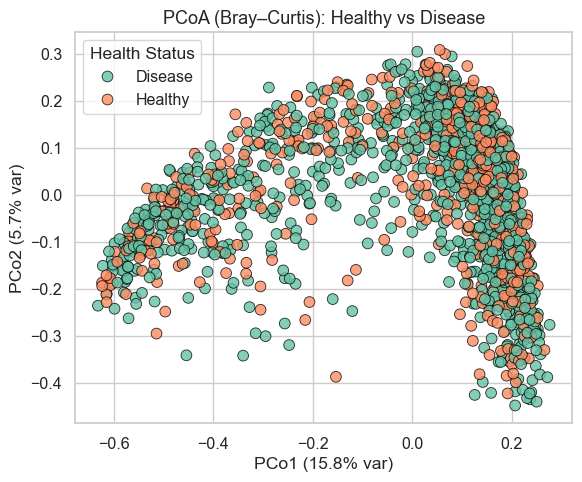

In [115]:
# PCoA plot colored by Health Status
plt.figure(figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=bc_df, x='PCo1', y='PCo2',
    hue='health_status', palette='Set2',
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCoA (Bray–Curtis): Healthy vs Disease", fontsize=13)
plt.xlabel(f"PCo1 ({bc_var[0]*100:.1f}% var)")
plt.ylabel(f"PCo2 ({bc_var[1]*100:.1f}% var)")
plt.legend(title="Health Status", frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_healthstatus.png"), dpi=300)
plt.show()

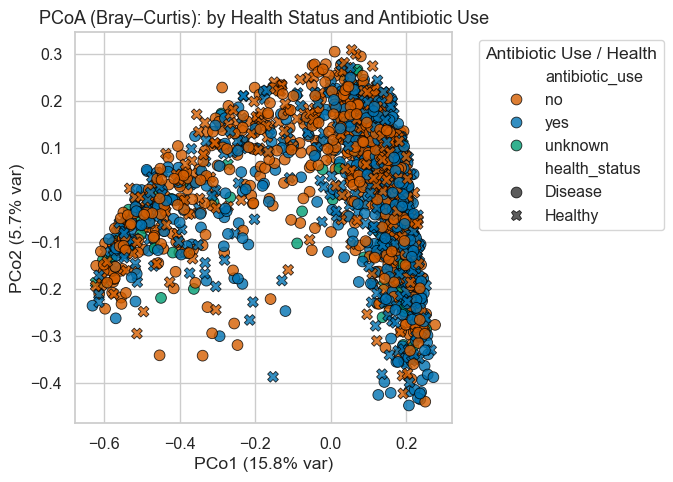

In [116]:
# Plot: PCoA colored by Antibiotic Use
plt.figure(figsize=(7,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=bc_df, x='PCo1', y='PCo2',
    hue='antibiotic_use', style='health_status',
    palette={'no':'#D55E00','yes':'#0072B2','unknown':'#009E73'},
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCoA (Bray–Curtis): by Health Status and Antibiotic Use", fontsize=13)
plt.xlabel(f"PCo1 ({bc_var[0]*100:.1f}% var)")
plt.ylabel(f"PCo2 ({bc_var[1]*100:.1f}% var)")
plt.legend(title="Antibiotic Use / Health", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


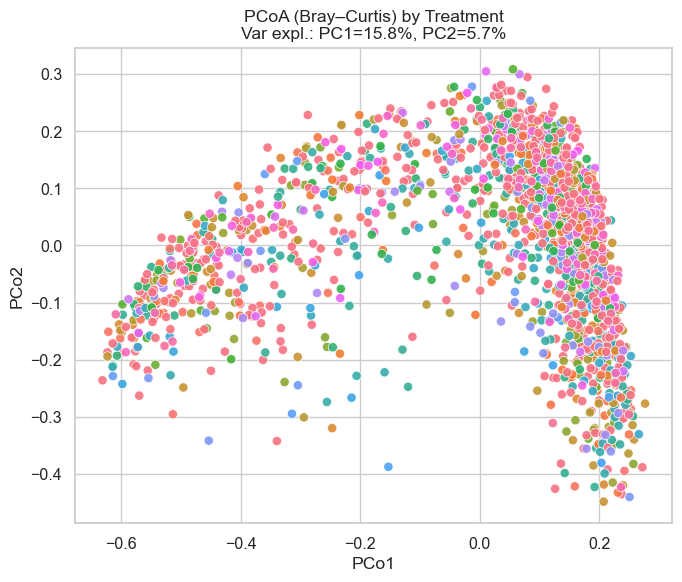

In [117]:
# PCoA colored by Treatment
if meta['treatment'].notna().sum() > 0 and meta['treatment'].nunique() > 1:
    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=bc_df, x='PCo1', y='PCo2',
        hue='treatment', s=45, edgecolor='white', alpha=0.9, legend=False
    )
    plt.title(f"PCoA (Bray–Curtis) by Treatment\nVar expl.: PC1={bc_var[0]:.1%}, PC2={bc_var[1]:.1%}")
    plt.xlabel("PCo1")
    plt.ylabel("PCo2")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, "pcoa_braycurtis_by_treatment.png"), dpi=300, bbox_inches='tight')
    plt.show()



In [118]:
# PERMANOVA on Bray–Curtis

dm = DistanceMatrix(bc_DM, ids=list(ab_rel.index))
# Health status
res_health = permanova(dm, bc_df['health_status'], permutations=999)
print("\nPERMANOVA (Bray–Curtis) ~ health_status")
print(res_health)
# Antibiotic use
res_abx = permanova(dm, bc_df['antibiotic_use'], permutations=999)
print("\nPERMANOVA (Bray–Curtis) ~ antibiotic_use")
print(res_abx)
# Save tables
with open(os.path.join(TABLES, "permanova_braycurtis.txt"), "w") as f:
    f.write("PERMANOVA (Bray–Curtis) ~ health_status\n")
    f.write(str(res_health) + "\n\n")
    f.write("PERMANOVA (Bray–Curtis) ~ antibiotic_use\n")
    f.write(str(res_abx) + "\n")



PERMANOVA (Bray–Curtis) ~ health_status
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  2
test statistic             4.094901
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMANOVA (Bray–Curtis) ~ antibiotic_use
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  3
test statistic             5.152043
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


# CLR + PCA

In [119]:
# CLR transform: add a small pseudocount to avoid log(0)
def clr_transform(df, pseudo=1e-6):
    X = df.values + pseudo
    logX = np.log(X)
    gm = logX.mean(axis=1, keepdims=True)  # per-sample geometric mean in log space
    clr = logX - gm
    return pd.DataFrame(clr, index=df.index, columns=df.columns)

ab_clr = clr_transform(ab_rel, pseudo=1e-6)

# PCA on CLR data (captures Aitchison structure)
pca = PCA(n_components=2, random_state=2025)
clr_pcs = pca.fit_transform(ab_clr.values)
clr_df = pd.DataFrame(clr_pcs, index=ab_rel.index, columns=['PC1', 'PC2'])
clr_df = clr_df.join(meta[['health_status', 'antibiotic_use', 'treatment']])

# Save coordinates
clr_df.to_csv(os.path.join(TABLES, "beta_aitchison_clr_pca_coords.csv"))


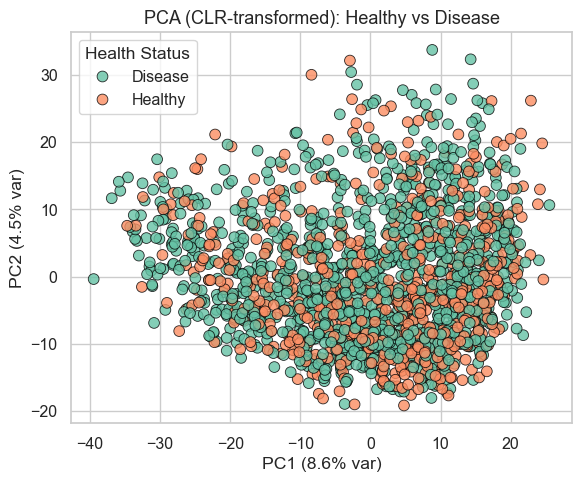

In [120]:
# Plot: PCA (CLR) colored by Health Status
plt.figure(figsize=(6,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=clr_df, x='PC1', y='PC2',
    hue='health_status', palette='Set2',
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCA (CLR-transformed): Healthy vs Disease", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Health Status")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pca_clr_healthstatus.png"), dpi=300)
plt.show()

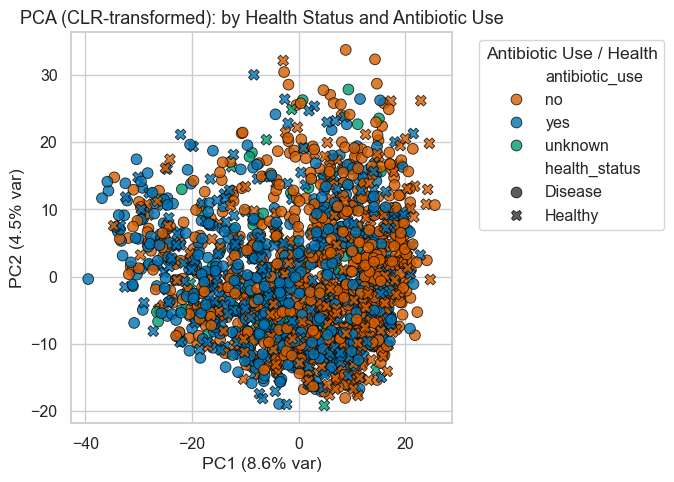

In [121]:
# Plot: PCA (CLR) colored by Antibiotic Use
plt.figure(figsize=(7,5))
sns.set(style="whitegrid", font_scale=1.05)
sns.scatterplot(
    data=clr_df, x='PC1', y='PC2',
    hue='antibiotic_use', style='health_status',
    palette={'no':'#D55E00','yes':'#0072B2','unknown':'#009E73'},
    s=60, edgecolor='black', alpha=0.8
)
plt.title("PCA (CLR-transformed): by Health Status and Antibiotic Use", fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Antibiotic Use / Health", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "pca_clr_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


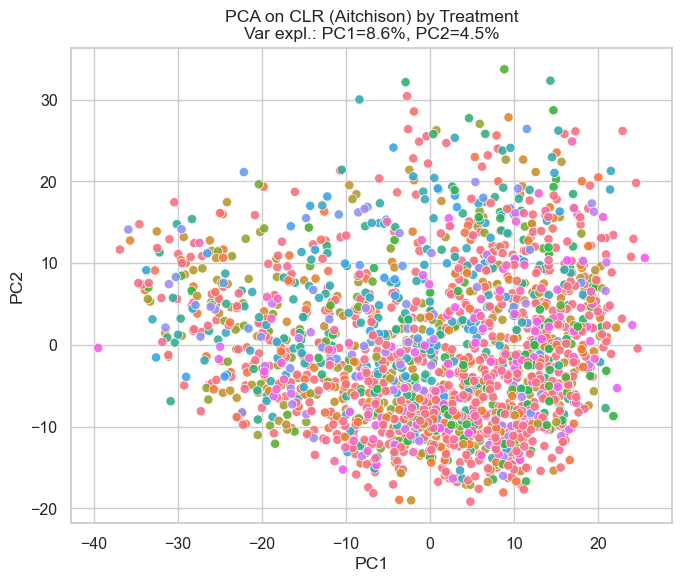

In [122]:
# by Treatment
if meta['treatment'].notna().sum() > 0 and meta['treatment'].nunique() > 1:
    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=clr_df, x='PC1', y='PC2',
        hue='treatment', s=45, edgecolor='white', alpha=0.9, legend=False
    )
    plt.title(f"PCA on CLR (Aitchison) by Treatment\nVar expl.: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, "pca_clr_by_treatment.png"), dpi=300, bbox_inches='tight')
    plt.show()



# PERMANOVA on Aitchison

In [123]:
# PERMANOVA on Aitchison (Euclidean on CLR space)
    # Euclidean distance in CLR space
clr_dist = pdist(ab_clr.values, metric='euclidean')
clr_DM = squareform(clr_dist)
dm_clr = DistanceMatrix(clr_DM, ids=list(ab_clr.index))
res_health_clr = permanova(dm_clr, clr_df['health_status'], permutations=999)
print("\nPERMANOVA (Aitchison/CLR Euclidean) ~ health_status")
print(res_health_clr)
res_abx_clr = permanova(dm_clr, clr_df['antibiotic_use'], permutations=999)
print("\nPERMANOVA (Aitchison/CLR Euclidean) ~ antibiotic_use")
print(res_abx_clr)
with open(os.path.join(TABLES, "permanova_aitchison_clr.txt"), "w") as f:
    f.write("PERMANOVA (Aitchison/CLR Euclidean) ~ health_status\n")
    f.write(str(res_health_clr) + "\n\n")
    f.write("PERMANOVA (Aitchison/CLR Euclidean) ~ antibiotic_use\n")
    f.write(str(res_abx_clr) + "\n")

print("[Info] PERMANOVA on Aitchison skipped (scikit-bio not installed).")


PERMANOVA (Aitchison/CLR Euclidean) ~ health_status
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  2
test statistic              5.50208
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMANOVA (Aitchison/CLR Euclidean) ~ antibiotic_use
method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1831
number of groups                  3
test statistic             5.424421
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
[Info] PERMANOVA on Aitchison skipped (scikit-bio not installed).


# Machine Learning Pipeline for Gut Microbiome Disease Prediction

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split, GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, balanced_accuracy_score,
                             precision_recall_curve, auc, make_scorer)
from sklearn.inspection import permutation_importance

import os

# Set random seed for reproducibility
np.random.seed(2025)

# Assuming you have these from previous code:
# ab_clr: CLR-transformed abundances (samples x taxa)
# meta: metadata with health_status, antibiotic_use, etc.
# alpha: alpha diversity metrics


## Data Preparation & Confounder Handling


In [39]:
def prepare_datasets(ab_clr, meta, alpha, strategy='exclude_antibiotics'):
    """
    Prepare feature matrix and labels with different confounder handling strategies.

    Parameters:
    -----------
    ab_clr : DataFrame
        CLR-transformed abundances
    meta : DataFrame
        Sample metadata
    alpha : DataFrame
        Alpha diversity metrics
    strategy : str
        'exclude_antibiotics': Remove antibiotic users
        'include_as_feature': Add antibiotic use as a feature
        'stratify': Keep all, stratify later in modeling

    Returns:
    --------
    X : array
        Feature matrix
    y : array
        Binary labels (0=Healthy, 1=Disease)
    sample_ids : Index
        Sample identifiers
    feature_names : list
        Feature names
    """

    # Align data
    common_idx = ab_clr.index.intersection(meta.index)
    X_abund = ab_clr.loc[common_idx].copy()
    meta_aligned = meta.loc[common_idx].copy()

    if strategy == 'exclude_antibiotics':
        # Remove antibiotic users
        keep_idx = meta_aligned['antibiotic_use'].isin(['no', 'unknown'])
        X_abund = X_abund[keep_idx]
        meta_aligned = meta_aligned[keep_idx]
        print(f"After excluding antibiotic users: {X_abund.shape[0]} samples")

    # Prepare feature matrix
    feature_names = list(X_abund.columns)

    if strategy == 'include_as_feature':
        # Add antibiotic use as binary feature
        abx_feature = (meta_aligned['antibiotic_use'] == 'yes').astype(int)
        X = np.column_stack([X_abund.values, abx_feature.values])
        feature_names.append('antibiotic_use')
    else:
        X = X_abund.values

    # Create binary labels
    y = (meta_aligned['health_status'] == 'Disease').astype(int).values

    # Print class distribution
    print(f"\nClass distribution:")
    print(f"  Healthy: {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
    print(f"  Disease: {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")

    return X, y, X_abund.index, feature_names


## Feature Selection


In [40]:
def select_features(X_train, y_train, feature_names, method='univariate', k=100):
    """
    Feature selection using different methods.

    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    feature_names : list
        Names of features
    method : str
        'univariate': ANOVA F-test
        'mutual_info': Mutual information
        'none': No selection
    k : Number of features to select
    """

    if method == 'none':
        print(f"No feature selection - using all {X_train.shape[1]} features")
        return None, feature_names

    k = min(k, X_train.shape[1])  # Don't select more than available

    if method == 'univariate':
        selector = SelectKBest(f_classif, k=k)
        print(f"Selecting top {k} features by ANOVA F-test")
    elif method == 'mutual_info':
        selector = SelectKBest(mutual_info_classif, k=k)
        print(f"Selecting top {k} features by mutual information")

    selector.fit(X_train, y_train)

    # Get selected feature names
    selected_idx = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_idx]

    # Print top 10 features with scores
    scores = pd.DataFrame({
        'feature': selected_features,
        'score': selector.scores_[selected_idx]
    }).sort_values('score', ascending=False)

    print(f"\nTop 10 selected features:")
    print(scores.head(10).to_string(index=False))

    return selector, selected_features


## Model Training & Evaluation


In [41]:
def evaluate_model_cv(model, X, y, model_name, cv=5):

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=2025)

    cv_results = cross_validate(
        model, X, y,
        cv=cv_splitter,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    print(f"{model_name}")


    results = {}
    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()

        results[metric] = {
            'train_mean': train_mean,
            'train_std': train_std,
            'test_mean': test_mean,
            'test_std': test_std
        }

        print(f"{metric:12s} - Train: {train_mean:.3f} ± {train_std:.3f}  |  "
              f"Test: {test_mean:.3f} ± {test_std:.3f}")

    # Check for overfitting
    auc_diff = results['roc_auc']['train_mean'] - results['roc_auc']['test_mean']
    if auc_diff > 0.1:
        print(f"\nPossible overfitting (train-test AUC gap: {auc_diff:.3f})")

    return results


In [42]:
def train_models(X, y, feature_names, cv_folds=5):
    """
    Train and compare multiple models.
    """

    all_results = {}
    fitted_models = {}

    # Calculate class weight for imbalanced data
    n_healthy = (y == 0).sum()
    n_disease = (y == 1).sum()
    scale_pos_weight = n_healthy / n_disease if n_disease > 0 else 1.0

    print(f"\nClass imbalance ratio: {scale_pos_weight:.2f}:1 (Healthy:Disease)")

    # 1. Logistic Regression (L2)
    print("MODEL 1: Logistic Regression (L2 regularization)")
    lr_l2 = LogisticRegressionCV(
        cv=5,
        penalty='l2',
        max_iter=1000,
        class_weight='balanced',
        random_state=2025,
        n_jobs=-1
    )
    results_lr_l2 = evaluate_model_cv(lr_l2, X, y, "Logistic Regression (L2)", cv=cv_folds)
    all_results['LogReg_L2'] = results_lr_l2
    lr_l2.fit(X, y)  # Fit on full data for later use
    fitted_models['LogReg_L2'] = lr_l2

    # 2. Logistic Regression (Elastic Net)
    print("MODEL 2: Logistic Regression (Elastic Net)")
    lr_enet = LogisticRegressionCV(
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[.1, .5, .7, .9, .95, .99],
        max_iter=2000,
        class_weight='balanced',
        random_state=2025,
        n_jobs=-1
    )
    results_lr_enet = evaluate_model_cv(lr_enet, X, y, "Logistic Regression (ElasticNet)", cv=cv_folds)
    all_results['LogReg_ElasticNet'] = results_lr_enet
    lr_enet.fit(X, y)
    fitted_models['LogReg_ElasticNet'] = lr_enet

    # 3. Random Forest
    print("MODEL 3: Random Forest")
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=2025,
        n_jobs=-1
    )
    results_rf = evaluate_model_cv(rf, X, y, "Random Forest", cv=cv_folds)
    all_results['RandomForest'] = results_rf
    rf.fit(X, y)
    fitted_models['RandomForest'] = rf

    # 4. Gradient Boosting
    print("MODEL 4: Gradient Boosting")
    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=2025
    )
    results_gb = evaluate_model_cv(gb, X, y, "Gradient Boosting", cv=cv_folds)
    all_results['GradientBoosting'] = results_gb
    gb.fit(X, y)
    fitted_models['GradientBoosting'] = gb

    return all_results, fitted_models


## Feature Importance Analysis


In [43]:
def analyze_feature_importance(fitted_models, feature_names, X, y, top_k=20):
    """
    Extract and visualize feature importance from different models.
    """

    importance_dict = {}

    # Logistic Regression coefficients
    if 'LogReg_L2' in fitted_models:
        lr_model = fitted_models['LogReg_L2']
        coefs = lr_model.coef_[0]
        importance_dict['LogReg_Coefficients'] = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefs,
            'abs_coefficient': np.abs(coefs)
        }).sort_values('abs_coefficient', ascending=False)

    # Random Forest feature importance
    if 'RandomForest' in fitted_models:
        rf_model = fitted_models['RandomForest']
        importance_dict['RF_Importance'] = pd.DataFrame({
            'feature': feature_names,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

    # Gradient Boosting feature importance
    if 'GradientBoosting' in fitted_models:
        gb_model = fitted_models['GradientBoosting']
        importance_dict['GB_Importance'] = pd.DataFrame({
            'feature': feature_names,
            'importance': gb_model.feature_importances_
        }).sort_values('importance', ascending=False)

    # Plot top features
    fig, axes = plt.subplots(1, len(importance_dict), figsize=(6*len(importance_dict), 6))
    if len(importance_dict) == 1:
        axes = [axes]

    for idx, (name, df) in enumerate(importance_dict.items()):
        top_features = df.head(top_k)

        if 'coefficient' in df.columns:
            # For logistic regression, show both positive and negative
            y_pos = np.arange(len(top_features))
            colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
            axes[idx].barh(y_pos, top_features['coefficient'], color=colors, alpha=0.7)
            axes[idx].set_xlabel('Coefficient (Disease ← | → Healthy)', fontsize=11)
        else:
            y_pos = np.arange(len(top_features))
            axes[idx].barh(y_pos, top_features['importance'], color='steelblue', alpha=0.7)
            axes[idx].set_xlabel('Importance', fontsize=11)

        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(top_features['feature'], fontsize=9)
        axes[idx].invert_yaxis()
        axes[idx].set_title(f'Top {top_k} Features - {name}', fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, 'feature_importance_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return importance_dict


## Model Comparison & Visualization


In [44]:
def plot_model_comparison(all_results, save_path=None):
    """
    comparison plots for all models.
    """

    # Extract test metrics
    models = list(all_results.keys())
    metrics = ['roc_auc', 'balanced_acc', 'precision', 'recall', 'f1']

    # Prepare data for plotting
    plot_data = []
    for model in models:
        for metric in metrics:
            plot_data.append({
                'Model': model,
                'Metric': metric.upper().replace('_', ' '),
                'Score': all_results[model][metric]['test_mean'],
                'Std': all_results[model][metric]['test_std']
            })

    df_plot = pd.DataFrame(plot_data)

    # Create grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(metrics))
    width = 0.2

    for idx, model in enumerate(models):
        model_data = df_plot[df_plot['Model'] == model]
        scores = model_data['Score'].values
        stds = model_data['Std'].values

        ax.bar(x + idx*width, scores, width, yerr=stds,
               label=model, alpha=0.8, capsize=5)

    ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison (Cross-Validation)', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    # Add horizontal line at 0.5 (random chance for AUC)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Random chance')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [45]:
def plot_roc_curves(fitted_models, X, y, cv_folds=5):
    """
    Plot ROC curves for all models using cross-validation.
    """

    fig, ax = plt.subplots(figsize=(8, 8))

    cv_splitter = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=2025)

    colors = plt.cm.Set2(np.linspace(0, 1, len(fitted_models)))

    for (model_name, model), color in zip(fitted_models.items(), colors):

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for fold, (train_idx, test_idx) in enumerate(cv_splitter.split(X, y)):
            # Fit model on this fold
            model_copy = model.__class__(**model.get_params())
            model_copy.fit(X[train_idx], y[train_idx])

            # Predict probabilities
            y_prob = model_copy.predict_proba(X[test_idx])[:, 1]

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y[test_idx], y_prob)
            roc_auc = auc(fpr, tpr)

            # Interpolate
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)

        # Compute mean and std
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        # Plot
        ax.plot(mean_fpr, mean_tpr, color=color, lw=2,
                label=f'{model_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

        # Plot std band
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=0.2)

    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)', alpha=0.5)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curves (Cross-Validation)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, 'roc_curves_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()


## Main Execution Pipeline


In [46]:
X, y, sample_ids, feature_names = prepare_datasets(
    ab_clr, meta, alpha,
    strategy='exclude_antibiotics'  # or 'include_as_feature'
)

print(f"\nFinal dataset: {X.shape[0]} samples × {X.shape[1]} features")


After excluding antibiotic users: 1048 samples

Class distribution:
  Healthy: 345 (32.9%)
  Disease: 703 (67.1%)

Final dataset: 1048 samples × 362 features


In [56]:
# Feature selection, or no feature selection?
print("Feature Selection")

# Split data for feature selection
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=2025
)

# Uncomment to use without feature selection
'''print("\n--- Without feature selection ---")
selector, selected_features = select_features(
    X_train_full, y_train_full, feature_names,
    method='none', k=100
)'''

# Uncomment to use feature selection:
print("\n--- With feature selection ---")
selector, selected_features = select_features(
    X_train_full, y_train_full, feature_names,
    method='univariate', k=100)
X = selector.transform(X)
feature_names = selected_features


Feature Selection

--- With feature selection ---
Selecting top 100 features by ANOVA F-test

Top 10 selected features:
                     feature     score
            Escherichia coli 39.185258
 [Bacteroides] pectinophilus 25.048742
      Streptococcus gordonii 18.838508
       Enterocloster bolteae 17.683211
         Eisenbergiella tayi 17.559919
     [Clostridium] symbiosum 16.756662
        Streptococcus oralis 16.276024
 Firmicutes bacterium CAG:95 16.252763
     Eubacterium sp. CAG:180 15.801935
Barnesiella intestinihominis 15.317759


In [57]:
# Train and evaluate models
print("Model Training & Cross-Validation")

all_results, fitted_models = train_models(X, y, feature_names, cv_folds=5)


Model Training & Cross-Validation

Class imbalance ratio: 0.49:1 (Healthy:Disease)
MODEL 1: Logistic Regression (L2 regularization)
Logistic Regression (L2)
roc_auc      - Train: 0.799 ± 0.006  |  Test: 0.744 ± 0.031
accuracy     - Train: 0.724 ± 0.007  |  Test: 0.682 ± 0.032
balanced_acc - Train: 0.733 ± 0.006  |  Test: 0.683 ± 0.035
precision    - Train: 0.857 ± 0.003  |  Test: 0.816 ± 0.028
recall       - Train: 0.706 ± 0.009  |  Test: 0.680 ± 0.033
f1           - Train: 0.774 ± 0.007  |  Test: 0.741 ± 0.028
MODEL 2: Logistic Regression (Elastic Net)
Logistic Regression (ElasticNet)
roc_auc      - Train: 0.747 ± 0.124  |  Test: 0.685 ± 0.094
accuracy     - Train: 0.717 ± 0.024  |  Test: 0.677 ± 0.012
balanced_acc - Train: 0.688 ± 0.094  |  Test: 0.643 ± 0.073
precision    - Train: 0.819 ± 0.074  |  Test: 0.784 ± 0.058
recall       - Train: 0.773 ± 0.114  |  Test: 0.741 ± 0.130
f1           - Train: 0.784 ± 0.010  |  Test: 0.751 ± 0.028
MODEL 3: Random Forest
Random Forest
roc_auc   

Visualization & Interpretation


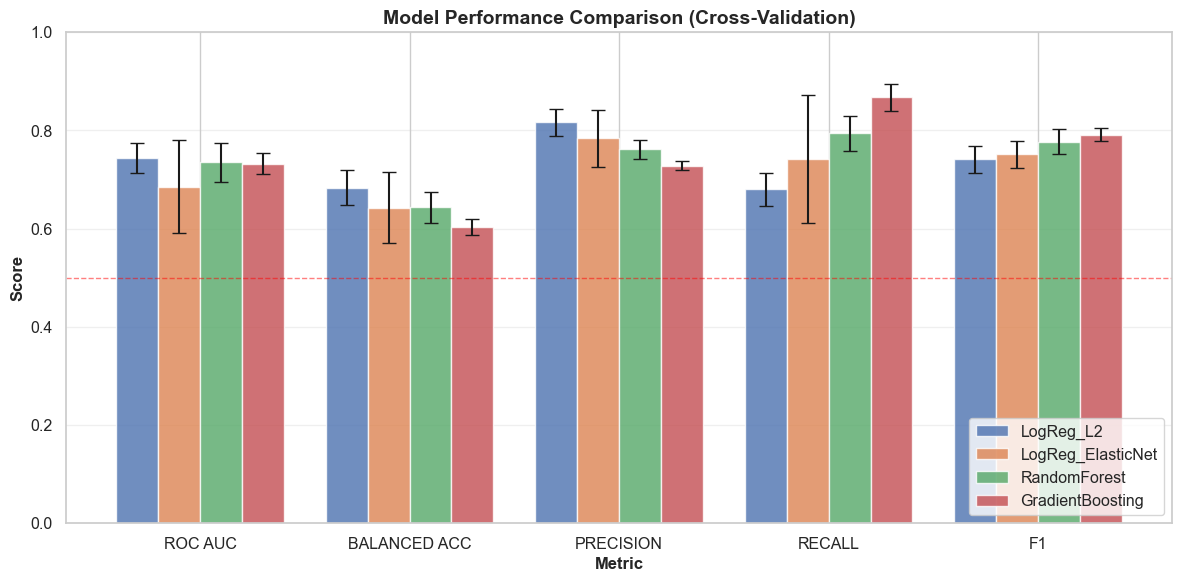

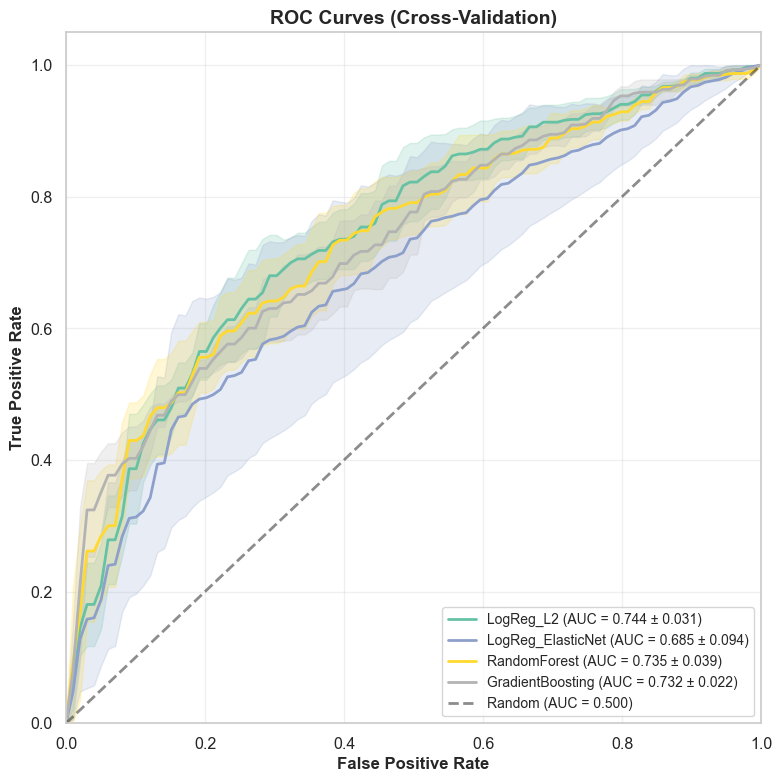

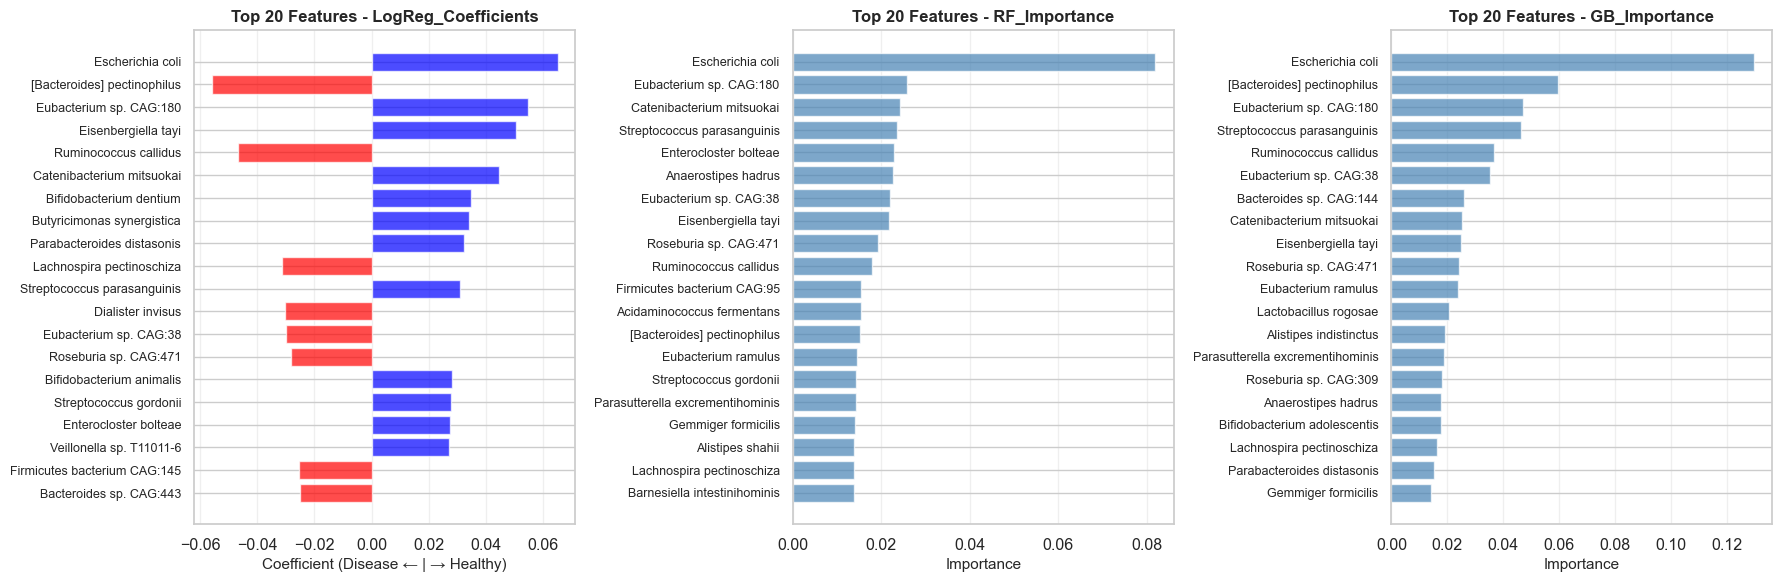

In [58]:
# Visualize results
print("Visualization & Interpretation")

# Model comparison
plot_model_comparison(all_results, save_path=os.path.join(FIGS, 'model_comparison.png'))

# ROC curves
plot_roc_curves(fitted_models, X, y, cv_folds=5)

# Feature importance
importance_results = analyze_feature_importance(
    fitted_models, feature_names, X, y, top_k=20
)


In [59]:
# Print summary table
print("FINAL RESULTS SUMMARY")

summary_data = []
for model_name, results in all_results.items():
    summary_data.append({
        'Model': model_name,
        'ROC-AUC': f"{results['roc_auc']['test_mean']:.3f} ± {results['roc_auc']['test_std']:.3f}",
        'Balanced Acc': f"{results['balanced_acc']['test_mean']:.3f} ± {results['balanced_acc']['test_std']:.3f}",
        'F1': f"{results['f1']['test_mean']:.3f} ± {results['f1']['test_std']:.3f}",
        'Precision': f"{results['precision']['test_mean']:.3f} ± {results['precision']['test_std']:.3f}",
        'Recall': f"{results['recall']['test_mean']:.3f} ± {results['recall']['test_std']:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(os.path.join(TABLES, 'model_performance_summary.csv'), index=False)


FINAL RESULTS SUMMARY
            Model       ROC-AUC  Balanced Acc            F1     Precision        Recall
        LogReg_L2 0.744 ± 0.031 0.683 ± 0.035 0.741 ± 0.028 0.816 ± 0.028 0.680 ± 0.033
LogReg_ElasticNet 0.685 ± 0.094 0.643 ± 0.073 0.751 ± 0.028 0.784 ± 0.058 0.741 ± 0.130
     RandomForest 0.735 ± 0.039 0.643 ± 0.032 0.777 ± 0.026 0.761 ± 0.019 0.794 ± 0.035
 GradientBoosting 0.732 ± 0.022 0.603 ± 0.016 0.792 ± 0.013 0.728 ± 0.009 0.868 ± 0.028


In [60]:
print("\nPipeline complete! Results saved to:")
print(f"   - {FIGS}/")
print(f"   - {TABLES}/")


Pipeline complete! Results saved to:
   - data/results_EDA/figures/
   - data/results_EDA/tables/


# Visualization of Classification Performance


In [61]:
def visualize_classification_results(best_model, X, y, sample_ids, meta, model_name='Best Model'):
    """
    Comprehensive visualization of how well the model separates classes.
    """

    print(f"Classification Visualization for {model_name}")

    # Get predictions
    y_pred = best_model.predict(X)
    y_prob = best_model.predict_proba(X)[:, 1]

    # Calculate metrics
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y, y_pred)
    accuracy = (y == y_pred).mean()

    print(f"\nOverall Accuracy: {accuracy:.3f}")
    print(f"Correctly classified: {(y == y_pred).sum()} / {len(y)}")
    print(f"Misclassified: {(y != y_pred).sum()} / {len(y)}")

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Disease'],
                yticklabels=['Healthy', 'Disease'],
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_ylabel('True Label', fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontweight='bold')
    ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=12)

    # Add percentages
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / cm[i].sum() * 100
            ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                    ha='center', va='center', fontsize=9, color='gray')

    # 2. Probability Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    healthy_probs = y_prob[y == 0]
    disease_probs = y_prob[y == 1]

    ax2.hist(healthy_probs, bins=30, alpha=0.6, label='True Healthy',
             color='green', edgecolor='black')
    ax2.hist(disease_probs, bins=30, alpha=0.6, label='True Disease',
             color='red', edgecolor='black')
    ax2.axvline(0.5, color='black', linestyle='--', linewidth=2,
                label='Threshold', alpha=0.7)
    ax2.set_xlabel('Predicted Probability (Disease)', fontweight='bold')
    ax2.set_ylabel('Count', fontweight='bold')
    ax2.legend(loc='upper center')
    ax2.set_title('Prediction Confidence Distribution', fontweight='bold', fontsize=12)
    ax2.grid(alpha=0.3)

    # 3. ROC Curve for this model
    ax3 = fig.add_subplot(gs[0, 2])
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    ax3.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate', fontweight='bold')
    ax3.set_ylabel('True Positive Rate', fontweight='bold')
    ax3.set_title('ROC Curve', fontweight='bold', fontsize=12)
    ax3.legend(loc='lower right')
    ax3.grid(alpha=0.3)

    # 4. UMAP Projection - True Labels
    ax4 = fig.add_subplot(gs[1, :2])
    try:
        from umap import UMAP
        print("\nComputing UMAP projection...")
        reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=2025, n_jobs=1)
        X_2d = reducer.fit_transform(X)

        # Plot true labels
        scatter = ax4.scatter(X_2d[:, 0], X_2d[:, 1],
                            c=y, cmap='RdYlGn_r',
                            s=30, alpha=0.6, edgecolors='black', linewidths=0.5)
        ax4.set_title('UMAP Projection - True Labels', fontweight='bold', fontsize=12)
        ax4.set_xlabel('UMAP 1', fontweight='bold')
        ax4.set_ylabel('UMAP 2', fontweight='bold')

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Healthy', 'Disease'])

    except ImportError:
        ax4.text(0.5, 0.5, 'UMAP not installed\npip install umap-learn',
                ha='center', va='center', fontsize=12)
        ax4.set_xlim([0, 1])
        ax4.set_ylim([0, 1])

    # 5. UMAP Projection - Predictions with Misclassifications
    ax5 = fig.add_subplot(gs[1, 2])
    try:
        # Plot predicted probabilities
        scatter2 = ax5.scatter(X_2d[:, 0], X_2d[:, 1],
                             c=y_prob, cmap='RdYlGn_r',
                             s=30, alpha=0.6, edgecolors='black', linewidths=0.5)

        # Highlight misclassifications
        misclassified = (y != y_pred)
        if misclassified.sum() > 0:
            ax5.scatter(X_2d[misclassified, 0], X_2d[misclassified, 1],
                       s=100, facecolors='none', edgecolors='red',
                       linewidths=2, label=f'Misclassified (n={misclassified.sum()})')
            ax5.legend(loc='best', fontsize=9)

        ax5.set_title('UMAP - Predicted Probability', fontweight='bold', fontsize=12)
        ax5.set_xlabel('UMAP 1', fontweight='bold')
        ax5.set_ylabel('UMAP 2', fontweight='bold')

        cbar2 = plt.colorbar(scatter2, ax=ax5)
        cbar2.set_label('P(Disease)', fontweight='bold')

    except (ImportError, NameError):
        pass

    # 6. Prediction Confidence by True Class
    ax6 = fig.add_subplot(gs[2, 0])

    data_for_violin = pd.DataFrame({
        'Probability': y_prob,
        'True Label': ['Healthy' if label == 0 else 'Disease' for label in y],
        'Correct': ['Correct' if y[i] == y_pred[i] else 'Wrong' for i in range(len(y))]
    })

    sns.violinplot(data=data_for_violin, x='True Label', y='Probability',
                   hue='Correct', split=True, ax=ax6, palette={'Correct': 'green', 'Wrong': 'red'})
    ax6.axhline(0.5, color='black', linestyle='--', alpha=0.5)
    ax6.set_title('Prediction Confidence by Outcome', fontweight='bold', fontsize=12)
    ax6.set_ylabel('Predicted P(Disease)', fontweight='bold')
    ax6.set_xlabel('')

    # 7. Metrics by Probability Threshold
    ax7 = fig.add_subplot(gs[2, 1])

    thresholds_to_test = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    f1_scores = []

    for thresh in thresholds_to_test:
        y_pred_thresh = (y_prob >= thresh).astype(int)

        tp = ((y_pred_thresh == 1) & (y == 1)).sum()
        fp = ((y_pred_thresh == 1) & (y == 0)).sum()
        fn = ((y_pred_thresh == 0) & (y == 1)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    ax7.plot(thresholds_to_test, precisions, label='Precision', linewidth=2)
    ax7.plot(thresholds_to_test, recalls, label='Recall', linewidth=2)
    ax7.plot(thresholds_to_test, f1_scores, label='F1', linewidth=2, linestyle='--')
    ax7.axvline(0.5, color='black', linestyle=':', alpha=0.5, label='Default (0.5)')
    ax7.set_xlabel('Probability Threshold', fontweight='bold')
    ax7.set_ylabel('Score', fontweight='bold')
    ax7.set_title('Metrics vs. Threshold', fontweight='bold', fontsize=12)
    ax7.legend(loc='best')
    ax7.grid(alpha=0.3)
    ax7.set_ylim([0, 1])

    # 8. Sample-level difficulty (sorted by confidence)
    ax8 = fig.add_subplot(gs[2, 2])

    # Calculate "difficulty" = distance from 0.5
    difficulty = np.abs(y_prob - 0.5)
    sorted_idx = np.argsort(difficulty)

    colors_samples = ['green' if y[i] == y_pred[i] else 'red' for i in sorted_idx]

    ax8.scatter(np.arange(len(y)), y_prob[sorted_idx],
               c=colors_samples, s=10, alpha=0.6)
    ax8.axhline(0.5, color='black', linestyle='--', alpha=0.5)
    ax8.set_xlabel('Samples (sorted by confidence)', fontweight='bold')
    ax8.set_ylabel('Predicted P(Disease)', fontweight='bold')
    ax8.set_title('Per-Sample Predictions', fontweight='bold', fontsize=12)
    ax8.set_ylim([0, 1])

    # Add legend manually
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', label='Correct'),
                      Patch(facecolor='red', label='Wrong')]
    ax8.legend(handles=legend_elements, loc='best', fontsize=9)

    plt.suptitle(f'{model_name} - Classification Performance Visualization',
                fontsize=16, fontweight='bold', y=0.995)

    plt.savefig(os.path.join(FIGS, 'classification_visualization_comprehensive.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # Return misclassified sample info
    misclassified_df = pd.DataFrame({
        'sample_id': sample_ids[y != y_pred],
        'true_label': ['Healthy' if y[i] == 0 else 'Disease' for i in range(len(y)) if y[i] != y_pred[i]],
        'predicted_label': ['Healthy' if y_pred[i] == 0 else 'Disease' for i in range(len(y)) if y[i] != y_pred[i]],
        'predicted_prob': y_prob[y != y_pred]
    })

    return misclassified_df



Best model: LogReg_L2
   ROC-AUC: 0.744
Classification Visualization for LogReg_L2

Overall Accuracy: 0.722
Correctly classified: 757 / 1048
Misclassified: 291 / 1048

Computing UMAP projection...


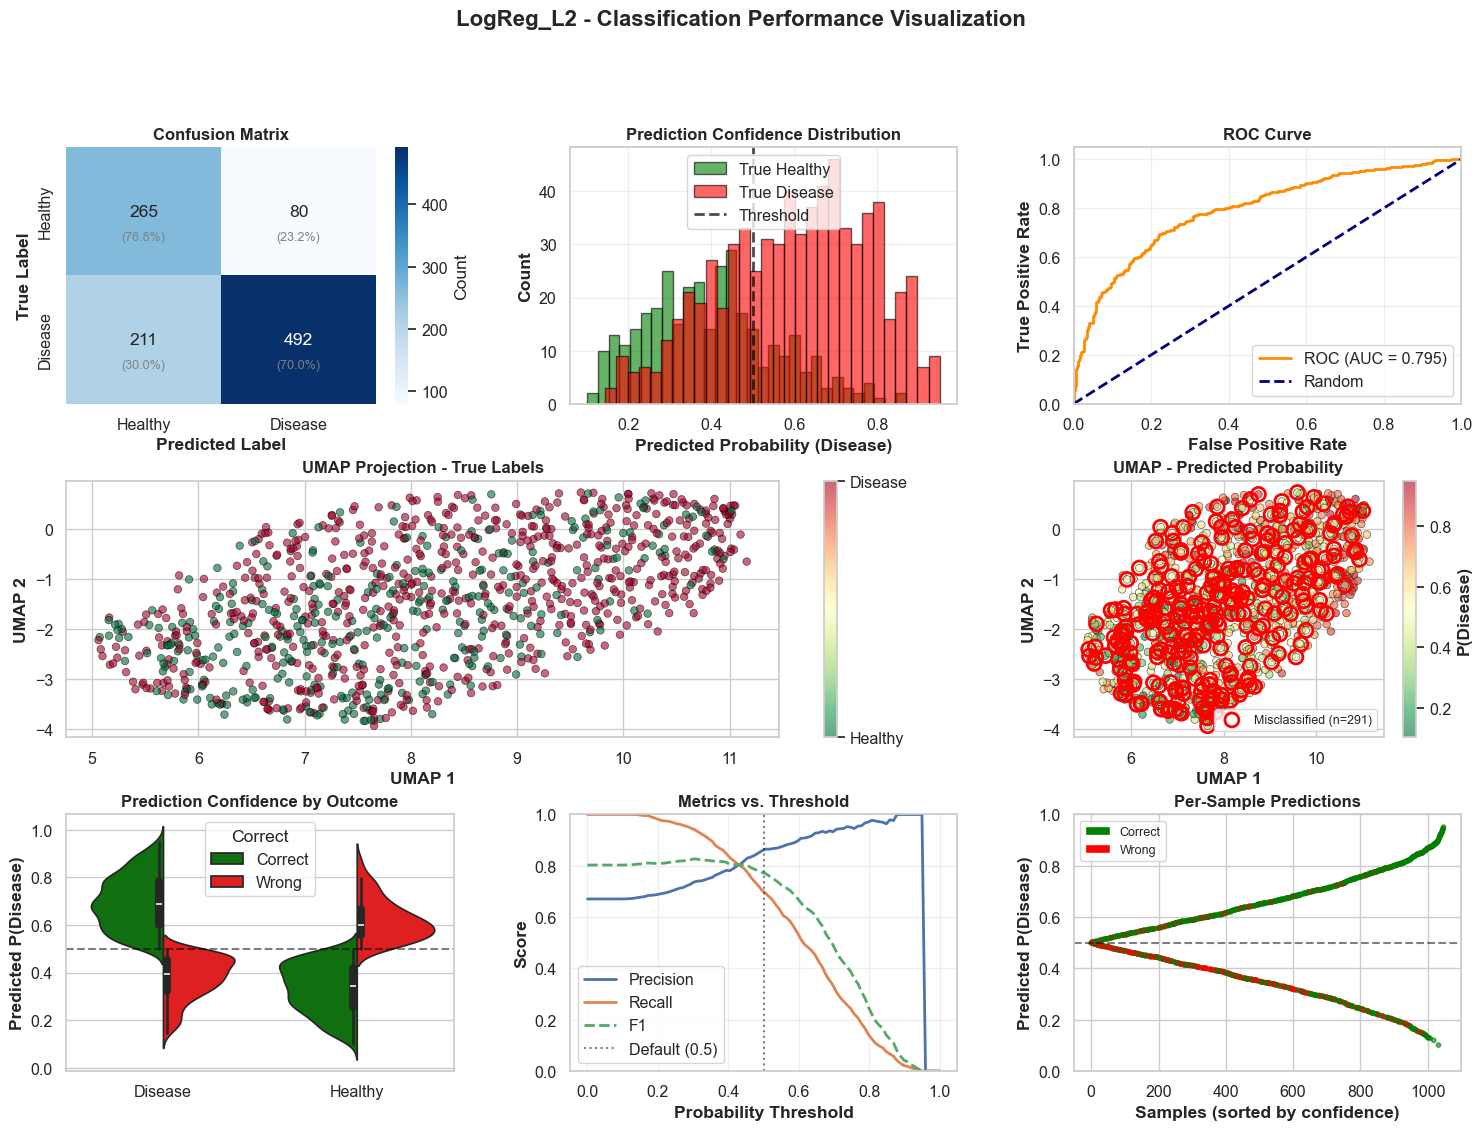


Misclassified samples saved to: data/results_EDA/tables/misclassified_samples.csv

Top 10 misclassified samples (most confident mistakes):
   sample_id true_label predicted_label  predicted_prob
M0x20MCx1599    Healthy         Disease        0.870394
M0x20MCx1500    Disease         Healthy        0.144620
M0x10MCx2077    Healthy         Disease        0.850543
M0x13MCx3311    Disease         Healthy        0.150005
M0x14MCx1338    Disease         Healthy        0.153382
M0x12MCx1988    Disease         Healthy        0.174946
M0x30MCx3372    Disease         Healthy        0.177422
M0x30MCx1576    Disease         Healthy        0.178441
M0x30MCx1346    Disease         Healthy        0.180161
M0x20MCx2653    Disease         Healthy        0.183859


In [62]:
# Find best model by ROC-AUC
best_model_name = max(all_results.keys(),
                      key=lambda k: all_results[k]['roc_auc']['test_mean'])
best_model = fitted_models[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"   ROC-AUC: {all_results[best_model_name]['roc_auc']['test_mean']:.3f}")

# Visualize classification results
misclassified_samples = visualize_classification_results(
    best_model, X, y, sample_ids, meta, model_name=best_model_name
)

# Save misclassified samples
if len(misclassified_samples) > 0:
    misclassified_samples.to_csv(
        os.path.join(TABLES, 'misclassified_samples.csv'),
        index=False
    )
    print(f"\nMisclassified samples saved to: {TABLES}/misclassified_samples.csv")
    print(f"\nTop 10 misclassified samples (most confident mistakes):")
    print(misclassified_samples.sort_values('predicted_prob',
          key=lambda x: np.abs(x - 0.5),
          ascending=False).head(10).to_string(index=False))


In [63]:
print("\nPipeline complete! Results saved to:")
print(f"   - {FIGS}/")
print(f"   - {TABLES}/")


Pipeline complete! Results saved to:
   - data/results_EDA/figures/
   - data/results_EDA/tables/


# Advanced Microbiome Analysis Pipeline
# Part 1: Disease-Specific Models
# Part 2: Enhanced Feature Engineering
# Part 3: Taxonomic Aggregation Analysis


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer, balanced_accuracy_score

import os

np.random.seed(2025)


## Part 1: Disease-Specific Modeling


In [159]:
def create_disease_groups(meta):
    """
    Create disease groupings based on biological similarity.
    """

    # Manual mapping
    manual_map = {
        'IGT': 'metabolic',
        'T2D': 'metabolic', 
        'control': 'control',
        'CAD': 'cardiovascular',
        'HF': 'cardiovascular'
    }
    
    meta['disease_group'] = meta['study_condition'].map(manual_map)

    print("\nDisease grouping:")
    print(meta['disease_group'].value_counts())
    print(f"\nPercentage breakdown:")
    print(meta['disease_group'].value_counts(normalize=True).round(3))

    return meta


In [164]:
def train_disease_specific_models(ab_clr, meta, feature_names):
    """
    Train separate models for each disease type vs. control.

    This addresses the heterogeneity problem by creating focused comparisons.
    """

    results_by_disease = {}

    # Ensure disease grouping exists
    if 'disease_group' not in meta.columns:
        meta = create_disease_groups(meta)

    # Get control samples
    control_idx = meta['disease_group'] == 'control'

    disease_groups = ['metabolic', 'cardiovascular']

    for disease_group in disease_groups:
        print(f"DISEASE-SPECIFIC MODEL: {disease_group.upper()} vs CONTROL")

        # Select samples: disease group + controls
        disease_idx = meta['disease_group'] == disease_group
        selected_idx = control_idx | disease_idx

        X_subset = ab_clr.loc[selected_idx].values
        y_subset = disease_idx[selected_idx].astype(int).values

        n_disease = y_subset.sum()
        n_control = (y_subset == 0).sum()

        print(f"Samples: {n_control} controls vs {n_disease} {disease_group}")

        # Train model
        model = LogisticRegressionCV(
            cv=5,
            penalty='l2',
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
        )


        # Cross-validation evaluation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

        scoring = {
            'roc_auc': 'roc_auc',
            'balanced_acc': make_scorer(balanced_accuracy_score),
            'f1': 'f1'
        }

        cv_results = cross_validate(
            model, X_subset, y_subset,
            cv=cv, scoring=scoring,
            return_train_score=True
        )

        # Store results
        results_by_disease[disease_group] = {
            'n_control': n_control,
            'n_disease': n_disease,
            'roc_auc': cv_results['test_roc_auc'].mean(),
            'roc_auc_std': cv_results['test_roc_auc'].std(),
            'balanced_acc': cv_results['test_balanced_acc'].mean(),
            'f1': cv_results['test_f1'].mean()
        }

        print(f"\nResults:")
        print(f"  ROC-AUC: {results_by_disease[disease_group]['roc_auc']:.3f} ± "
              f"{results_by_disease[disease_group]['roc_auc_std']:.3f}")
        print(f"  Balanced Accuracy: {results_by_disease[disease_group]['balanced_acc']:.3f}")
        print(f"  F1 Score: {results_by_disease[disease_group]['f1']:.3f}")

        # Fit model on full subset for feature importance
        model.fit(X_subset, y_subset)

        # Get top features
        coefs = model.coef_[0]
        top_idx = np.argsort(np.abs(coefs))[-20:][::-1]

        print(f"\nTop 10 discriminative taxa for {disease_group}:")
        for i, idx in enumerate(top_idx[:10], 1):
            direction = "↑" if coefs[idx] > 0 else "↓"
            print(f"  {i:2d}. {feature_names[idx][:50]:50s} {direction} ({coefs[idx]:+.3f})")

        results_by_disease[disease_group]['model'] = model
        results_by_disease[disease_group]['top_features'] = [feature_names[i] for i in top_idx]
        results_by_disease[disease_group]['top_coefs'] = coefs[top_idx]

    return results_by_disease


In [165]:
def compare_disease_models(results_by_disease, save_path=None):
    """
    Visualize comparison between disease-specific models.
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Performance comparison
    diseases = list(results_by_disease.keys())
    metrics = ['roc_auc', 'balanced_acc', 'f1']

    x = np.arange(len(diseases))
    width = 0.25

    for i, metric in enumerate(metrics):
        values = [results_by_disease[d][metric] for d in diseases]
        axes[0].bar(x + i*width, values, width, label=metric.upper().replace('_', ' '), alpha=0.8)

    axes[0].set_ylabel('Score', fontweight='bold')
    axes[0].set_title('Disease-Specific Model Performance', fontweight='bold')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels([d.capitalize() for d in diseases])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0, 1])
    axes[0].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')

    # 2. Sample sizes
    n_controls = [results_by_disease[d]['n_control'] for d in diseases]
    n_diseases = [results_by_disease[d]['n_disease'] for d in diseases]

    axes[1].bar(x, n_controls, width*2, label='Control', alpha=0.8, color='green')
    axes[1].bar(x, n_diseases, width*2, bottom=n_controls, label='Disease', alpha=0.8, color='red')

    axes[1].set_ylabel('Number of Samples', fontweight='bold')
    axes[1].set_title('Sample Distribution by Disease Group', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([d.capitalize() for d in diseases])
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## Part 2: Enhanced Feature Engineering


In [180]:
def engineer_clinical_features(meta):
    """
    Extract and engineer features from clinical metadata.
    """

    print("FEATURE ENGINEERING FROM CLINICAL METADATA")

    clinical_features = pd.DataFrame(index=meta.index)

    # 1. BMI categories
    if 'BMI' in meta.columns:
        clinical_features['BMI'] = meta['BMI']
        
        clinical_features['is_obese'] = (meta['BMI'] >= 30).astype(float)
        print(f"✓ BMI features: {clinical_features['BMI'].notna().sum()} samples")

    # 2. Age category
    if 'age_category' in meta.columns:
        age_dummies = pd.get_dummies(meta['age_category'], prefix='age', drop_first=True)
        clinical_features = pd.concat([clinical_features, age_dummies], axis=1)
        print(f"✓ Age categories: {meta['age_category'].nunique()} groups")

    # 3. Gender
    if 'gender' in meta.columns:
        clinical_features['is_male'] = (meta['gender'].str.lower() == 'male').astype(float)
        print(f"✓ Gender: {clinical_features['is_male'].notna().sum()} samples")

    # 4. Metabolic markers (z-scored)
    metabolic_markers = ['triglycerides', 'hba1c', 'LDL', 'hsCRP']
    for marker in metabolic_markers:
        if marker in meta.columns:
            # Z-score normalization
            values = meta[marker].astype(float)
            mean = values.mean()
            std = values.std()
            if std > 0:
                clinical_features[f'{marker}_zscore'] = (values - mean) / std
                print(f"✓ {marker}: {values.notna().sum()} samples (mean={mean:.1f}, std={std:.1f})")

    # 5. Smoking status
    if 'smoke' in meta.columns:
        clinical_features['is_smoker'] = meta['smoke'].notna().astype(float)
        print(f"✓ Smoking: {clinical_features['is_smoker'].sum()} smokers")

    # 6. Treatment indicator
    if 'treatment' in meta.columns:
        clinical_features['on_treatment'] = meta['treatment'].notna().astype(float)
        print(f"✓ Treatment: {clinical_features['on_treatment'].sum()} on treatment")

    # 7. Geographic region
    if 'country' in meta.columns:
        country_counts = meta['country'].value_counts()
        # Keep only countries with >50 samples, group rest as 'other'
        common_countries = country_counts[country_counts > 50].index
        meta['country_grouped'] = meta['country'].apply(
            lambda x: x if x in common_countries else 'other'
        )
        country_dummies = pd.get_dummies(meta['country_grouped'], prefix='country', drop_first=True)
        clinical_features = pd.concat([clinical_features, country_dummies], axis=1)
        print(f"✓ Country: {len(common_countries)} major countries")

    # 8. Antibiotic use
    if 'antibiotic_use' in meta.columns:
        clinical_features['antibiotic_yes'] = (meta['antibiotic_use'] == 'yes').astype(float)
        clinical_features['antibiotic_unknown'] = (meta['antibiotic_use'] == 'unknown').astype(float)
        print(f"✓ Antibiotics: yes={clinical_features['antibiotic_yes'].sum()}, "
              f"unknown={clinical_features['antibiotic_unknown'].sum()}")

    # Summary
    print(f"\nTotal clinical features created: {clinical_features.shape[1]}")
    print(f"Features with >70% coverage:")
    coverage = clinical_features.notna().mean()
    high_coverage = coverage[coverage > 0.7].sort_values(ascending=False)
    for feat, cov in high_coverage.items():
        print(f"  {feat:30s}: {cov*100:.1f}%")

    return clinical_features


In [181]:
def combine_features(ab_clr, clinical_features, alpha_diversity=None):
    """
    Combine microbiome abundances with clinical features.
    """

    print("COMBINING FEATURE SETS")

    # Align indices
    common_idx = ab_clr.index.intersection(clinical_features.index)

    X_microbiome = ab_clr.loc[common_idx]
    X_clinical = clinical_features.loc[common_idx]

    print(f"Microbiome features: {X_microbiome.shape[1]}")
    print(f"Clinical features: {X_clinical.shape[1]}")

    # Optional: Add alpha diversity
    if alpha_diversity is not None:
        alpha_subset = alpha_diversity.loc[common_idx, ['richness', 'shannon', 'simpson']]
        X_combined = pd.concat([X_microbiome, X_clinical, alpha_subset], axis=1)
        print(f"Alpha diversity features: {alpha_subset.shape[1]}")
    else:
        X_combined = pd.concat([X_microbiome, X_clinical], axis=1)

    # Handle missing values in clinical features
    # Strategy: Fill with median for continuous, 0 for binary indicators
    for col in X_combined.columns:
        if X_combined[col].isna().any():
            if X_combined[col].nunique() <= 2:  # Binary
                X_combined[col] = X_combined[col].fillna(0)
            else:  # Continuous
                X_combined[col] = X_combined[col].fillna(X_combined[col].median())

    print(f"\nCombined feature matrix: {X_combined.shape}")
    print(f"Missing values: {X_combined.isna().sum().sum()}")

    return X_combined


## Part 3: Taxonomic Aggregation Analysis


In [182]:
def aggregate_by_taxonomy(ab_rel, taxa_meta, level='phylum'):
    """
    Aggregate species-level abundances to higher taxonomic levels.

    Parameters:
    -----------
    ab_rel : DataFrame
        Relative abundances (samples x species)
    taxa_meta : DataFrame
        Taxonomic metadata for each species
    level : str
        Taxonomic level: 'phylum', 'class', 'order', 'family', 'genus'

    Returns:
    --------
    ab_aggregated : DataFrame
        Aggregated abundances
    """

    print(f"\nAggregating to {level} level...")

    # Align abundance table with taxonomy
    common_taxa = ab_rel.columns.intersection(taxa_meta.index)
    ab_subset = ab_rel[common_taxa]
    taxa_subset = taxa_meta.loc[common_taxa]

    # Group by taxonomic level and sum
    level_groups = taxa_subset.groupby(level).groups

    ab_aggregated = pd.DataFrame(index=ab_subset.index)

    for taxon, species_list in level_groups.items():
        if pd.notna(taxon):  # Skip unclassified
            ab_aggregated[taxon] = ab_subset[species_list].sum(axis=1)

    print(f"  Species-level: {len(common_taxa)} taxa")
    print(f"  {level.capitalize()}-level: {ab_aggregated.shape[1]} taxa")
    print(f"  Coverage: {(ab_aggregated.sum(axis=1).mean())*100:.1f}% of reads")

    return ab_aggregated


In [183]:
def analyze_taxonomic_signatures(ab_rel, taxa_meta, meta, disease_groups):
    """
    Identify taxonomic groups enriched in different diseases.
    """

    print("TAXONOMIC SIGNATURE ANALYSIS")

    results = {}

    levels = ['phylum', 'family', 'genus']

    for level in levels:
        print(f"\n--- {level.upper()} Level ---")

        # Aggregate abundances
        ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

        # Align with metadata
        common_idx = ab_agg.index.intersection(meta.index)
        ab_agg_aligned = ab_agg.loc[common_idx]
        meta_aligned = meta.loc[common_idx]

        # For each disease group, find enriched taxa
        enriched_taxa = {}

        for disease_group in disease_groups:
            if disease_group == 'control':
                continue

            disease_samples = meta_aligned['disease_group'] == disease_group
            control_samples = meta_aligned['disease_group'] == 'control'

            # Mann-Whitney U test for each taxon
            pvalues = []
            fold_changes = []
            taxa_names = []

            for taxon in ab_agg_aligned.columns:
                disease_abund = ab_agg_aligned.loc[disease_samples, taxon]
                control_abund = ab_agg_aligned.loc[control_samples, taxon]

                # Skip if too sparse
                if (disease_abund > 0).sum() < 5 or (control_abund > 0).sum() < 5:
                    continue

                # Test
                try:
                    stat, pval = stats.mannwhitneyu(disease_abund, control_abund, alternative='two-sided')

                    # Fold change (log2)
                    mean_disease = disease_abund.mean() + 1e-10
                    mean_control = control_abund.mean() + 1e-10
                    fc = np.log2(mean_disease / mean_control)

                    pvalues.append(pval)
                    fold_changes.append(fc)
                    taxa_names.append(taxon)
                except:
                    continue

            # FDR correction
            from statsmodels.stats.multitest import multipletests
            if len(pvalues) > 0:
                reject, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_bh')

                # Store results
                results_df = pd.DataFrame({
                    'taxon': taxa_names,
                    'log2_FC': fold_changes,
                    'pvalue': pvalues,
                    'padj': pvals_corrected,
                    'significant': reject
                })

                # Sort by abs(log2FC) among significant
                sig_results = results_df[results_df['significant']].copy()
                sig_results = sig_results.sort_values('log2_FC', key=abs, ascending=False)

                enriched_taxa[disease_group] = sig_results

                print(f"\n{disease_group.upper()} vs Control:")
                print(f"  Significant taxa: {sig_results.shape[0]} / {len(pvalues)}")

                if sig_results.shape[0] > 0:
                    print(f"  Top 5 enriched in {disease_group}:")
                    top_enriched = sig_results[sig_results['log2_FC'] > 0].head(5)
                    for _, row in top_enriched.iterrows():
                        print(f"    {row['taxon']:30s}: FC={2**row['log2_FC']:.2f}x, padj={row['padj']:.2e}")

                    print(f"  Top 5 depleted in {disease_group}:")
                    top_depleted = sig_results[sig_results['log2_FC'] < 0].head(5)
                    for _, row in top_depleted.iterrows():
                        print(f"    {row['taxon']:30s}: FC={2**row['log2_FC']:.2f}x, padj={row['padj']:.2e}")

        results[level] = enriched_taxa

    return results


In [184]:
def plot_taxonomic_heatmap(ab_rel, taxa_meta, meta, level='phylum', top_n=15):
    """
    Create heatmap of top taxa across disease groups.
    """

    # Aggregate
    ab_agg = aggregate_by_taxonomy(ab_rel, taxa_meta, level=level)

    # Align
    common_idx = ab_agg.index.intersection(meta.index)
    ab_agg = ab_agg.loc[common_idx]
    meta_aligned = meta.loc[common_idx]

    # Get top N most abundant taxa overall
    mean_abundance = ab_agg.mean(axis=0).sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index

    # Calculate mean abundance per disease group
    disease_groups = ['control', 'metabolic', 'cardiovascular']

    heatmap_data = []
    for disease_group in disease_groups:
        group_samples = meta_aligned['disease_group'] == disease_group
        group_means = ab_agg.loc[group_samples, top_taxa].mean(axis=0)
        heatmap_data.append(group_means.values)

    heatmap_df = pd.DataFrame(
        heatmap_data,
        index=[g.capitalize() for g in disease_groups],
        columns=top_taxa
    ).T

    # Plot
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(heatmap_df, cmap='YlOrRd', annot=True, fmt='.3f',
                cbar_kws={'label': 'Mean Relative Abundance'},
                linewidths=0.5, ax=ax)
    ax.set_title(f'Top {top_n} {level.capitalize()} by Disease Group',
                fontweight='bold', fontsize=14)
    ax.set_xlabel('Disease Group', fontweight='bold')
    ax.set_ylabel(level.capitalize(), fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(FIGS, f'taxonomic_heatmap_{level}.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    return heatmap_df


## Execute Advanced Pipeline


In [185]:
# Step 1: Create disease groups
meta = create_disease_groups(meta)

print(meta)


Disease grouping:
disease_group
metabolic         825
control           642
cardiovascular    364
Name: count, dtype: int64

Percentage breakdown:
disease_group
metabolic         0.451
control           0.351
cardiovascular    0.199
Name: proportion, dtype: float64
                     study_name    subject_id body_site  \
M0x10MCx1134  MetaCardis_2020_a  M0x10MCx1134     stool   
M0x10MCx1135  MetaCardis_2020_a  M0x10MCx1135     stool   
M0x10MCx1138  MetaCardis_2020_a  M0x10MCx1138     stool   
M0x10MCx1140  MetaCardis_2020_a  M0x10MCx1140     stool   
M0x10MCx1143  MetaCardis_2020_a  M0x10MCx1143     stool   
...                         ...           ...       ...   
M0x30MCx3384  MetaCardis_2020_a  M0x30MCx3384     stool   
M0x30MCx3412  MetaCardis_2020_a  M0x30MCx3412     stool   
M0x30MCx3414  MetaCardis_2020_a  M0x30MCx3414     stool   
M0x30MCx3422  MetaCardis_2020_a  M0x30MCx3422     stool   
M0x30MCx3423  MetaCardis_2020_a  M0x30MCx3423     stool   

             antibiotics

TRAINING DISEASE-SPECIFIC MODELS
DISEASE-SPECIFIC MODEL: METABOLIC vs CONTROL
Samples: 642 controls vs 825 metabolic

Results:
  ROC-AUC: 0.725 ± 0.015
  Balanced Accuracy: 0.662
  F1 Score: 0.689

Top 10 discriminative taxa for metabolic:
   1. Escherichia coli                                   ↑ (+0.043)
   2. Eubacterium sp. CAG:180                            ↑ (+0.020)
   3. Lachnospira pectinoschiza                          ↓ (-0.018)
   4. Ruminococcus bromii                                ↑ (+0.017)
   5. Clostridium sp. CAG:167                            ↓ (-0.015)
   6. Firmicutes bacterium CAG:95                        ↓ (-0.015)
   7. Eubacterium sp. CAG:38                             ↓ (-0.014)
   8. Catenibacterium mitsuokai                          ↑ (+0.014)
   9. Anaerostipes hadrus                                ↓ (-0.013)
  10. [Ruminococcus] lactaris                            ↓ (-0.013)
DISEASE-SPECIFIC MODEL: CARDIOVASCULAR vs CONTROL
Samples: 642 controls vs 364 c

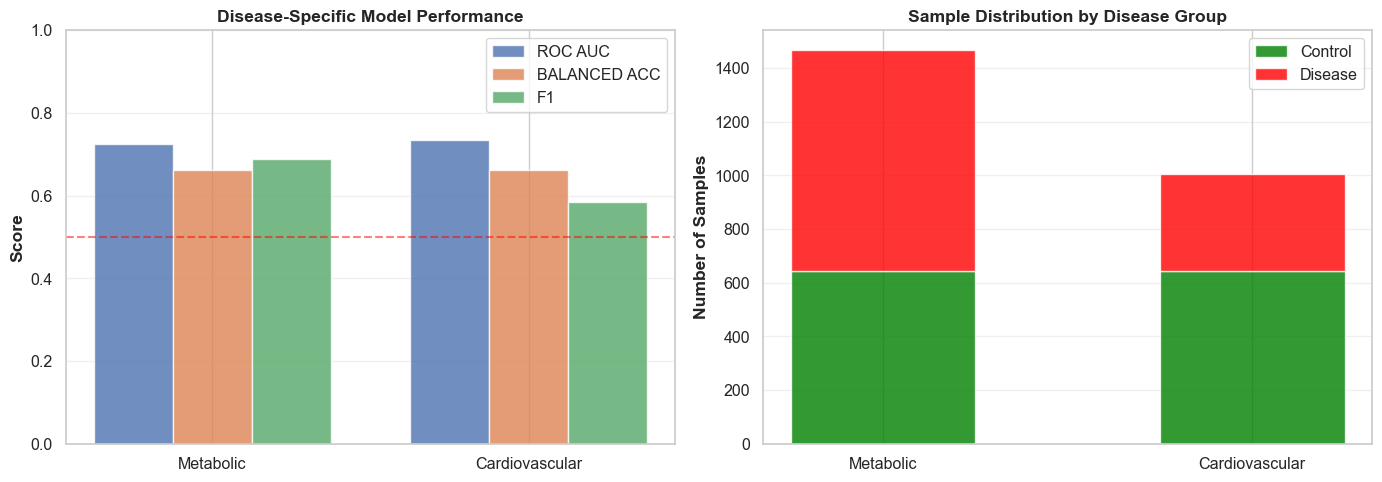

In [175]:
# Step 2: Disease-specific models
print("TRAINING DISEASE-SPECIFIC MODELS")

disease_results = train_disease_specific_models(ab_clr, meta, list(ab_clr.columns))

# Compare performance
compare_disease_models(disease_results,
                      save_path=os.path.join(FIGS, 'disease_specific_comparison.png'))


In [186]:
# Step 3: Feature engineering
clinical_features = engineer_clinical_features(meta)

# Combine with microbiome data
X_combined = combine_features(ab_clr, clinical_features, alpha_diversity=alpha)

# Train model with combined features
print("TRAINING MODEL WITH MICROBIOME + CLINICAL FEATURES")


# Split by disease group again
meta_combined = meta.loc[X_combined.index]
y_combined = (meta_combined['health_status'] == 'Disease').astype(int).values

model_combined = LogisticRegressionCV(
            cv=5,
            penalty='l2',
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
cv_results_combined = cross_validate(
    model_combined, X_combined.values, y_combined,
    cv=cv, scoring={'roc_auc': 'roc_auc', 'balanced_acc': make_scorer(balanced_accuracy_score)},
    return_train_score=True
)

print(f"Combined Model Performance:")
print(f"  ROC-AUC: {cv_results_combined['test_roc_auc'].mean():.3f} ± "
      f"{cv_results_combined['test_roc_auc'].std():.3f}")
print(f"  Balanced Acc: {cv_results_combined['test_balanced_acc'].mean():.3f}")


FEATURE ENGINEERING FROM CLINICAL METADATA
✓ BMI features: 1310 samples
✓ Age categories: 2 groups
✓ Gender: 1831 samples
✓ triglycerides: 844 samples (mean=117.5, std=75.7)
✓ hba1c: 839 samples (mean=5.6, std=0.4)
✓ LDL: 841 samples (mean=125.6, std=36.2)
✓ hsCRP: 829 samples (mean=102.7, std=228.1)
✓ Smoking: 1303.0 smokers
✓ Treatment: 1831.0 on treatment
✓ Country: 3 major countries
✓ Antibiotics: yes=783.0, unknown=104.0

Total clinical features created: 14
Features with >70% coverage:
  is_obese                      : 100.0%
  age_senior                    : 100.0%
  is_male                       : 100.0%
  is_smoker                     : 100.0%
  on_treatment                  : 100.0%
  country_DNK                   : 100.0%
  country_FRA                   : 100.0%
  antibiotic_yes                : 100.0%
  antibiotic_unknown            : 100.0%
  BMI                           : 71.5%
COMBINING FEATURE SETS
Microbiome features: 362
Clinical features: 14
Alpha diversity features:

TAXONOMIC SIGNATURE ANALYSIS

--- PHYLUM Level ---

Aggregating to phylum level...
  Species-level: 362 taxa
  Phylum-level: 12 taxa
  Coverage: 100.0% of reads

METABOLIC vs Control:
  Significant taxa: 6 / 12
  Top 5 enriched in metabolic:
    Synergistetes                 : FC=8.86x, padj=2.34e-04
    Proteobacteria                : FC=1.86x, padj=5.54e-12
  Top 5 depleted in metabolic:
    Spirochaetes                  : FC=0.33x, padj=2.22e-03
    Candidatus Melainabacteria    : FC=0.70x, padj=3.18e-02
    Euryarchaeota                 : FC=0.81x, padj=3.91e-02
    Firmicutes                    : FC=0.93x, padj=2.82e-03

CARDIOVASCULAR vs Control:
  Significant taxa: 1 / 12
  Top 5 enriched in cardiovascular:
    Synergistetes                 : FC=2.66x, padj=3.49e-02
  Top 5 depleted in cardiovascular:

--- FAMILY Level ---

Aggregating to family level...
  Species-level: 362 taxa
  Family-level: 48 taxa
  Coverage: 98.2% of reads

METABOLIC vs Control:
  Significant taxa: 13 / 4

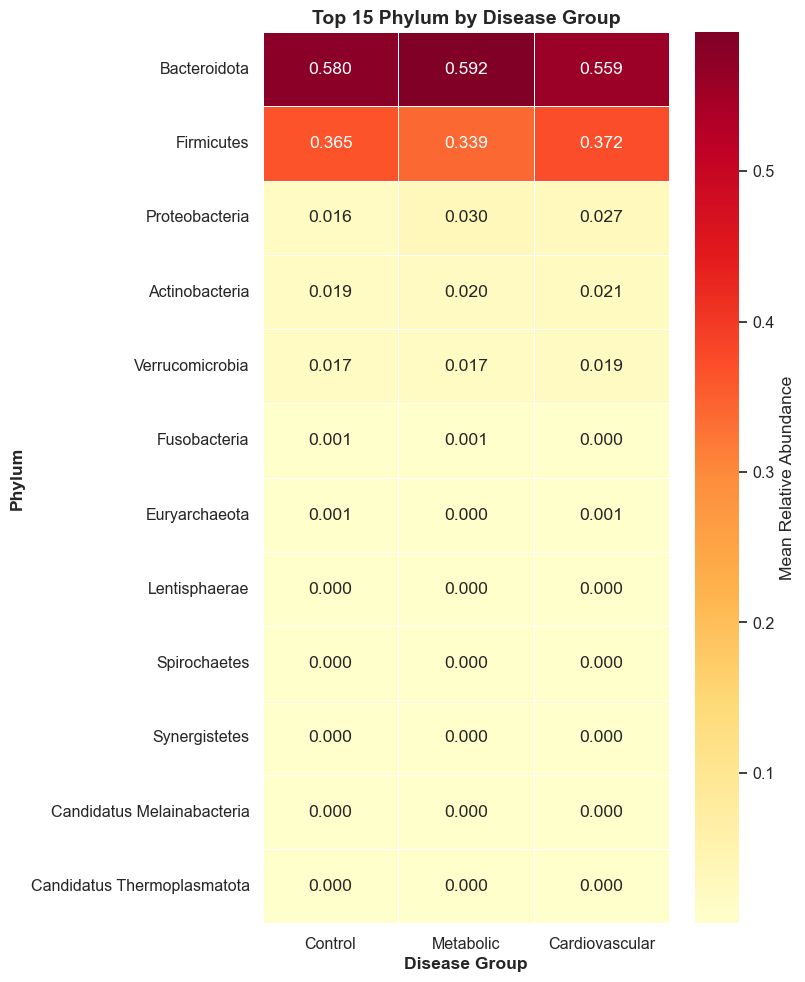


Aggregating to family level...
  Species-level: 362 taxa
  Family-level: 48 taxa
  Coverage: 98.2% of reads


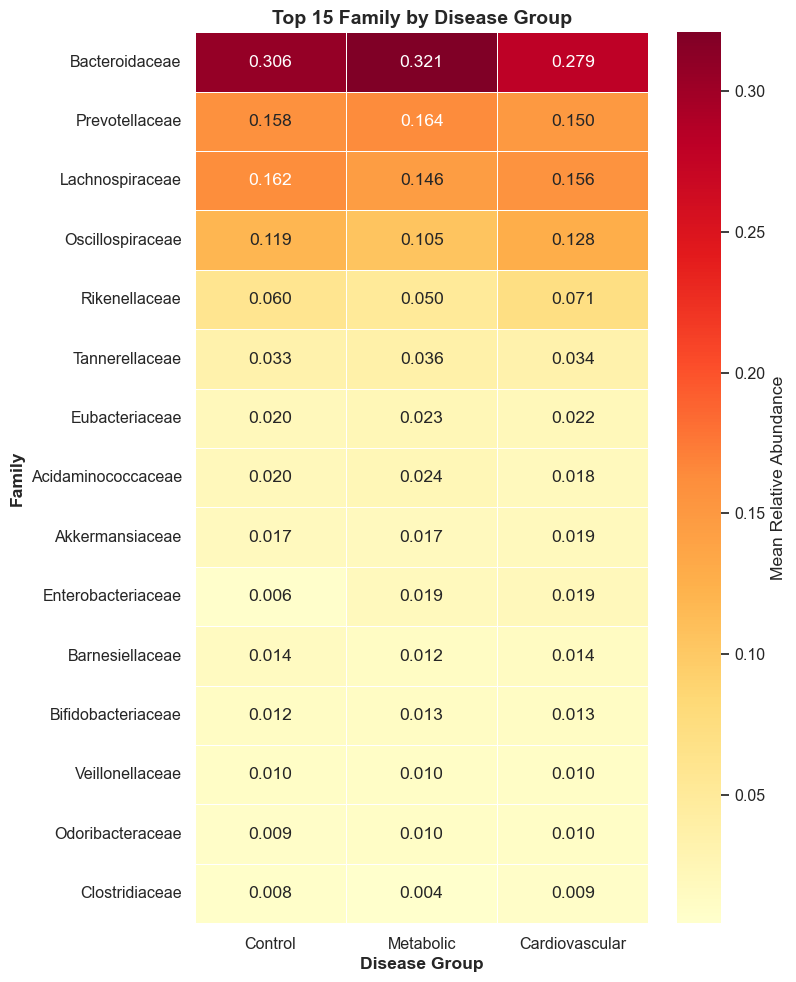

In [190]:
# Step 4: Taxonomic analysis
taxonomic_results = analyze_taxonomic_signatures(
    ab_rel, taxa_meta, meta,
    disease_groups=['metabolic', 'cardiovascular']
)

# Create heatmaps at different levels
for level in ['phylum', 'family']:
    heatmap_df = plot_taxonomic_heatmap(ab_rel, taxa_meta, meta, level=level, top_n=15)


In [188]:
# Step 5: Save all results
print("SAVING RESULTS")

# Save disease-specific model results
disease_summary = pd.DataFrame([
    {
        'disease_group': disease,
        'n_samples': results['n_disease'],
        'roc_auc': results['roc_auc'],
        'roc_auc_std': results['roc_auc_std'],
        'balanced_acc': results['balanced_acc'],
        'f1': results['f1']
    }
    for disease, results in disease_results.items()
])
disease_summary.to_csv(os.path.join(TABLES, 'disease_specific_results.csv'), index=False)

# Save taxonomic signatures
for level, disease_dict in taxonomic_results.items():
    for disease, results_df in disease_dict.items():
        filename = f'taxonomic_signatures_{level}_{disease}.csv'
        results_df.to_csv(os.path.join(TABLES, filename), index=False)

print("\nAdvanced analysis complete!")
print(f"Results saved to: {FIGS}/ and {TABLES}/")

SAVING RESULTS

Advanced analysis complete!
Results saved to: data/results_EDA/figures/ and data/results_EDA/tables/
